<h1 style="text-align: center;"><b>Modern Topics in Interest Rates Modelling</b></h1>

### Roland Grinis
### Home assignement: Plamadealov Alexey, MIF.


In [55]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

In [56]:
from pyquant.torch_spline import PchipSpline1D
from pyquant.plot_utils import plot_volatility_surface
from pyquant.interest_rates import *

In [57]:
#data
fwd_ois = pd.read_csv('data/forward_ois.csv')
fwd_key_rate = pd.read_csv('data/forward_key_rate.csv')
vol_key_rate = pd.read_csv('data/volatility_key_rate.csv')

## 1. Risk Free Rates (RFRs)

### 1.1 Extended $T$-forward measure

Short (risk-free, OIS) rate $r_t$ gives rise to bank account numeraire:

$$
dB_t = r_t B_t dt, \quad B_t = \exp \left( \int_0^t r_u du \right)
$$

The associated risk neutral measure $Q$ is called the money-savings measure
Investing in the bank account after maturity, we obtain the extended zero-coupon: 
$$
P_{t,T} = 
\begin{cases}
  \mathbb{E}^Q_t \left[ \exp \left(- \int_{t}^T r_u du \right) \right] , & t\leq T\\
  \exp \left(- \int_{t}^T r_u du \right) = \frac{B_t}{B_T},            & t > T
\end{cases}
$$

The associated risk-neutral measure, denoted $Q^T$, corresponds to the $T$-forward measure for $t \leq T$
and the money-savings measure $Q$ after maturity.   

### 1.2 Backward-looking forward rates

Forward Rate Agreement (FRA) contract has present value:

$$
PV_t = B_t \cdot \mathbb{E}^Q_{t} \left[ \tau \frac{\mathcal{P}_{T-\tau, T} - K}{B_T}  \right]
$$

with forward looking payoff:

$$
\mathcal{P}_{T-\tau, T} \equiv \mathcal{P}_{T-\tau, T} \left[ T' \rightarrow P_{T-\tau, T'} \right]
$$

or backward looking payoff:
$$
\mathcal{P}_{T-\tau, T} \equiv \mathcal{P}_{T-\tau, T} \left[ r_d \in \mathcal{B}(T - \tau, T) \right]
$$
where $\mathcal{B}(T - \tau, T)$ runs over business days in $\left[ T - \tau, T \right)$.

For example, the simple daily-compounded setting-in-arrears rates read:
$$
R_T \coloneqq R(T-\tau, T) = \mathcal{P}_{T-\tau, T} = \frac{1}{\tau} \left( \prod_{t \leq t_n < t+\tau} \left(1 + \tau_n r_{t_n} \right) - 1 \right)
$$

Or the daily arithmetic average setting-in-arrears rates read:

$$
A(T - \tau, T) = \mathcal{P}_{T-\tau, T} = \frac{1}{\tau} \sum_{t \leq t_n < t+\tau} \tau_n r_{t_n} 
$$

Passing to continous modelling:
$$
R(T - \tau, T)\approx  \frac{1}{\tau} \left[ \exp \left( \int_{T - \tau}^T r_u du \right)  - 1\right], \quad A(T - \tau, T)\approx \frac{1}{\tau} \int_{T - \tau}^T r_u du 
$$

and we get the relation:
$$
A(T - \tau, T) \approx \frac{1}{\tau} \log \left(1 + \tau R(T - \tau, T)\right)
$$



Passing to the extended $T$-forward measure, we obtain the compound forward rate as:
$$
R_{t,T} \coloneqq R_t(T - \tau, T) = \mathbb{E}^{Q^T}_{t} \left[  R(T - \tau, T) \right]
$$

which make $PV_t = 0$. We can evaluate the expectation:


* for $t \leq T-\tau$, $ R_{t,T} = \frac{1}{\tau} \left( \frac{P_{t, T - \tau}}{P_{t,T}} - 1\right)$ is analogous to IBOR forward rates.
* for $ T-\tau < t \leq T$, $ R_{t,T} = \frac{1}{\tau} \left( \frac{B_t}{B_{T - \tau} P_{t,T}} - 1\right)$ is daily compounding.
* post maturity $ R_{t,T} \equiv \frac{1}{\tau} \left( \frac{B_{T}}{B_{T - \tau}}  - 1\right) = R(T - \tau, T)$ is known and fixed.

  
The yield curve $T \rightarrow P_{t,T}$ can be boostrapped from $T \rightarrow  R_{t,T}$ quotes.

The arithmetic average forward rate can be expressed as:
$$
A_{t,T} \coloneqq  A_t(T - \tau, T) = \mathbb{E}^{Q^T}_{t} \left[ \frac{1}{\tau} \log \left(1 + \tau R(T - \tau, T)\right) \right]
$$
and since the payoff is non-linear, $A_{t,T}$ is model dependent. A convexity correction can appear compared to market quotes:
$$
A_{t,T} = \frac{1}{\tau} \log \left(1 + \tau R_{t,T}\right) + \text{Convexity Correction}
$$

#### 1.2.1 Interest Rate Swap
Interest Rate Swap (IRS) based on simple daily-compounding backward rates values:
$$
PV_t = \sum_{i=1}^n \tau_i P_{t,T_i}R_t(T_{i-1}, T_i) - K \cdot  \sum_{j=1}^m \tau'_i P_{t, T'_j}
$$
with floating leg tenors $T_0, \dots, T_n$ and fixed leg $T'_0, \dots, T'_m$ tenors. 

For $t < T_0$ forward swap rate with associated present value of a basis point evaluates:
$$
S_t(T_0, T_n) = \frac{P_{t,T_0} - P_{t,T_n}}{\text{PVBP}(t)} , \quad \text{PVBP}(t) = \sum_{j=1}^m \tau'_j P_{t, T'_j}
$$

Consider the OIS FRA quotes:

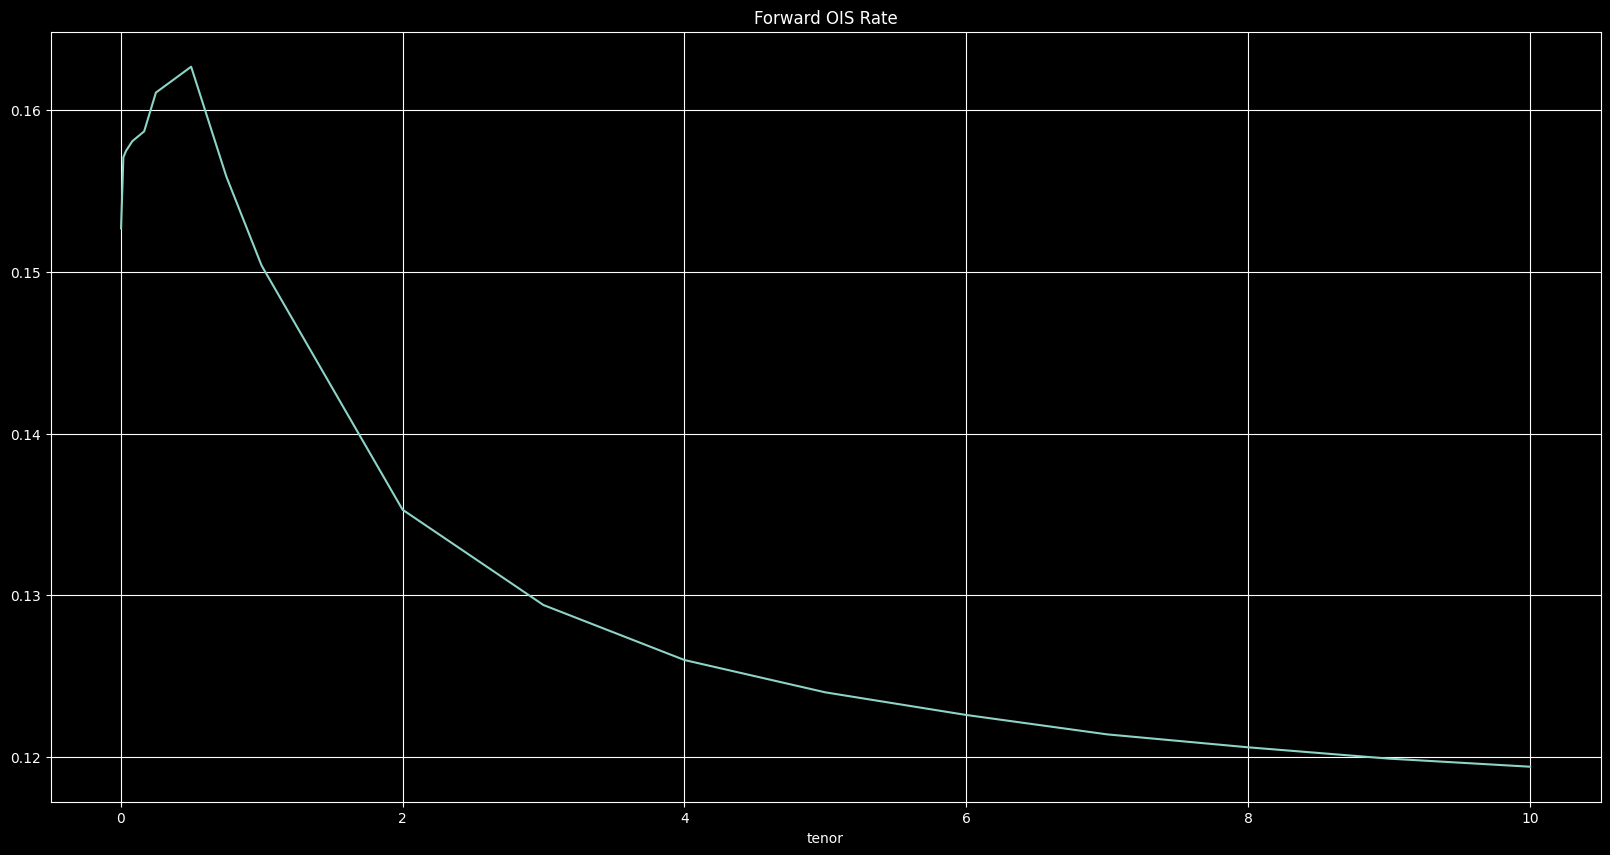

In [58]:
fwd_ois.set_index('tenor').sort_index().forward_rate.plot(title='Forward OIS Rate', grid=True, figsize=(20,10));

Compute the yield curve $T \rightarrow P_{t,T}$  using the above quotes.

In [59]:
ois_yield_curve = build_ois_yield_curve_from_now_starting(
    torch.tensor(fwd_ois.forward_rate.values),
    torch.tensor(fwd_ois.tenor.values)
)

Let's compute IRS swap rates with tenors ranging from 1M to 10Y starting overnight, to bootstrap the yield curve $P_{t,T}$ back. In fact, the swap rate formula leads to a linear equation:
$$
P_{t,T_m} + \tau S_t(T_{1,\dots,m}) \sum_{j=1}^m P_{t, T_j} = 1
$$
where the coupons $P_{t,T_i}$ are variables and different swap quotes $S_t(  T_{m, \dots, n})$ lead to a system of linear equations that can be solved using the SVD method for $P_{t,T_i}$. One can then fit a polynomial model to smooth out the yield curve.

In [60]:
tau = 1/12
n_coupons = 120
maturities = tau * torch.ones(n_coupons).cumsum(0)
num_months = 1 + torch.arange(0, n_coupons, step=1)
n_tenors = num_months.numel()
A = torch.zeros((n_tenors,120))
for i in range(n_tenors):
    n_months = num_months[i].item()
    payment_dates = (1 + torch.arange(n_months)) * tau
    zcb_last = ois_yield_curve.evaluate(payment_dates[-1]).sum()
    tau_swap_rate = (1 - zcb_last) / ois_yield_curve.evaluate(payment_dates).sum()
    for j in range(n_months):
        A[i][j] = tau_swap_rate.item()
    A[i][n_months-1] += 1
U, S, Vh = torch.linalg.svd(A)

In [61]:
bootstrap_zcb = torch.mv(Vh[:n_tenors].t(), torch.mv(U.t(), torch.ones(n_tenors)) / S)

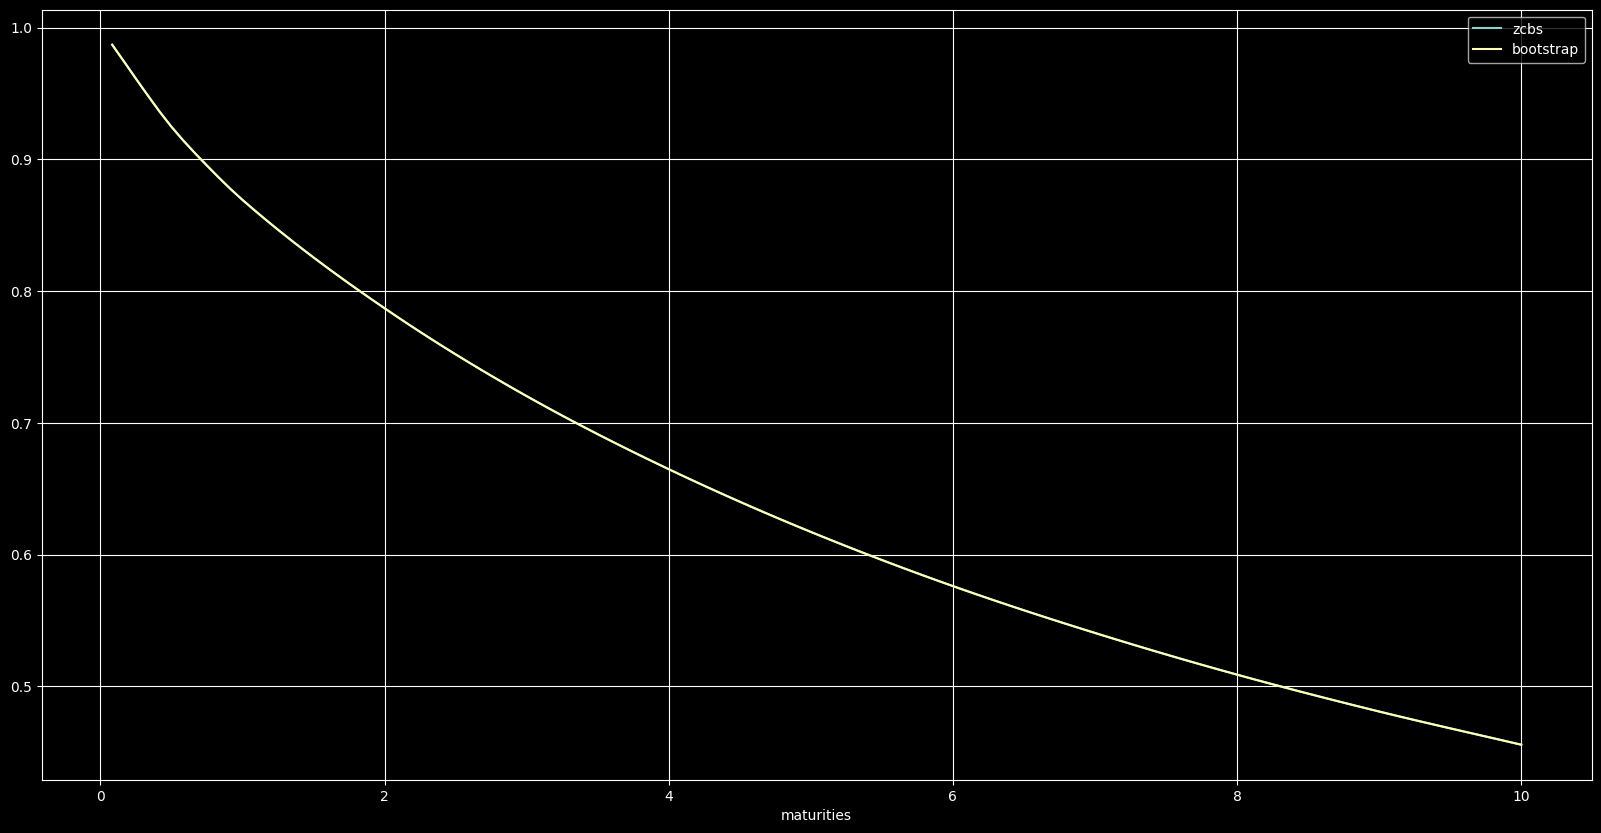

In [62]:
pd.DataFrame({
    'maturities' : maturities,
    'zcbs': ois_yield_curve.evaluate(maturities).flatten(),
    'bootstrap': bootstrap_zcb.numpy()}).set_index('maturities').plot(legend=True, grid=True, figsize=(20,10));

### 1.3 Forward Market Model (FMM)
As we approach maturity $T$, backward-looking rates settle to constant, and we need to choose a cutoff function to dampen volatility. 
  
A typical example is the linear cutoff $g_{t,T} = (T-t)^+ / \tau $ for $t \in (T-\tau, T)$ with $g_{t,T} \equiv 1$ for $t \leq T-\tau$ and $g_{t,T} \equiv 0$, $t \geq T$.  
  
In extended $T$-forward measure:
$$
dR_{t,T} = g_{t,T} \sigma_{t,T} (R_{t,T}) dW_t^{Q^T} \quad \text{martingale,}
$$

where $\sigma_{t,T} \equiv \sigma^T$ (Bachelier), or $\sigma_{t,T} \equiv \sigma^T R_{t,T}$ (Black), or  $\sigma_{t,T} \equiv \sigma^T (R_{t,T})^{\beta}$ (CEV), or Dupire local vol, or stochastic vol etc. with (multi-dimensional) Brownian motion $W_{t,T}$

In bank account numeraire $B_t$, we get the drift:
$$
dR_{t,T} = g_{t,T} \sigma_{t,T}(R_{t,T}) \left[
\sum_{T' < T}\rho_{T',T} \frac{\tau' g_{t,T'} \sigma_{t,T'}(R_{t,T'})}{1 + \tau' R_{t,T'} } dt + dW_t^Q
\right]
$$
where the sum runs over shorter tenors and $\rho$ holds the correlation structure of the curve.

#### 1.3.1 Caplet Pricing

Using $P_{t,T}$ as numeraire, for simply-compound rates:

$$
V^{\text{Caplet}}_t \left[ R_{t,T}, K \right] = P_{t,T} \mathbb{E}_{t}^{Q^T} \left[ \tau \left( R(T-\tau, T) - K \right)^+ \right] 
$$

For arithmetic average compound rates, the choice of cutoff $g_{t,T}$ influence directly the convexity correction. 
One should attempt to choose it such that we have:
$$
V^{\text{Caplet}}_t \left[ A_{t,T}, K \right] = P_{t,T} \mathbb{E}_{t}^{Q^T} \left[ \tau \left( A(T-\tau, T) - K \right)^+ \right] =  P_{t,T} \mathbb{E}_{t}^{Q^T} \left[  \left( \log \left(1 + \tau R(T - \tau, T)\right)  - \tau K \right)^+ \right] 
$$ 

As reference, using the linear cutoff:
$$
\hat{g}_{t,T}^2 \coloneqq \int_{t,T} g_{t,T}^2(s)ds = 
\begin{cases}
  T - t - \frac{2}{3}\tau,  & t\leq T-\tau \\
  \frac{(T-t)^3}{3\tau^2},  & t > T - \tau
\end{cases}
$$

Bachelier model:
$$
dR_{t,T} = g_{t,T} \sigma dW_t^{Q^T}, \quad R(T-\tau, T) \sim \mathcal{N}\left(R_{t,T}, (\sigma\hat{g}_{t,T})^2 \right) 
$$ 


Black model:
$$
dR_{t,T} = g_{t,T} R_{t,T} \sigma dW_t^{Q^T}, \quad R(T-\tau, T) = R_{t,T} \exp \left( - \frac{(\sigma\hat{g}_{t,T})^2 }{2} + \mathcal{N}\left(0, (\sigma\hat{g}_{t,T})^2 \right)  \right)
$$

Market makers formula convention for arithmetic-average compound rates:
$$
V^{\text{Caplet}}_t \left[ A'_{t,T}, K \right] = \tau P_{t,T}\left[ \left( A'_{t,T} - K\right) \Phi\left(\frac{A'_{t,T} - K}{\sigma \hat{g}_{t,T} }\right) + \sigma \hat{g}_{t,T} \phi\left(\frac{A'_{t,T} - K}{\sigma \hat{g}_{t,T} }\right)\right]
$$
which is the Bachelier model (normal volatility, $\Phi$ and $\phi$ are normal distribution CDF and PDF respectively), or:
$$
V^{\text{Caplet}}_t \left[ A'_{t,T}, K \right] = \tau P_{t,T}\left[ A'_{t,T} \Phi\left(d_{+}\right) - K \Phi \left(d_{-} \right) \right], \quad d_{\pm} = \frac{\log (A'_{t,T} / K) \pm (\sigma \hat{g}_{t,T})^2 / 2 }{\sigma\hat{g}_{t,T}}
$$
with the Black model (log-normal volatility). No convexity correction is taken into account. However, the discounting $P_{t,T}$ is done with respect to the OIS curve, even if  $A'_{t,T}$ correspond to a different RFR rate (e.g. a Key Rate). 

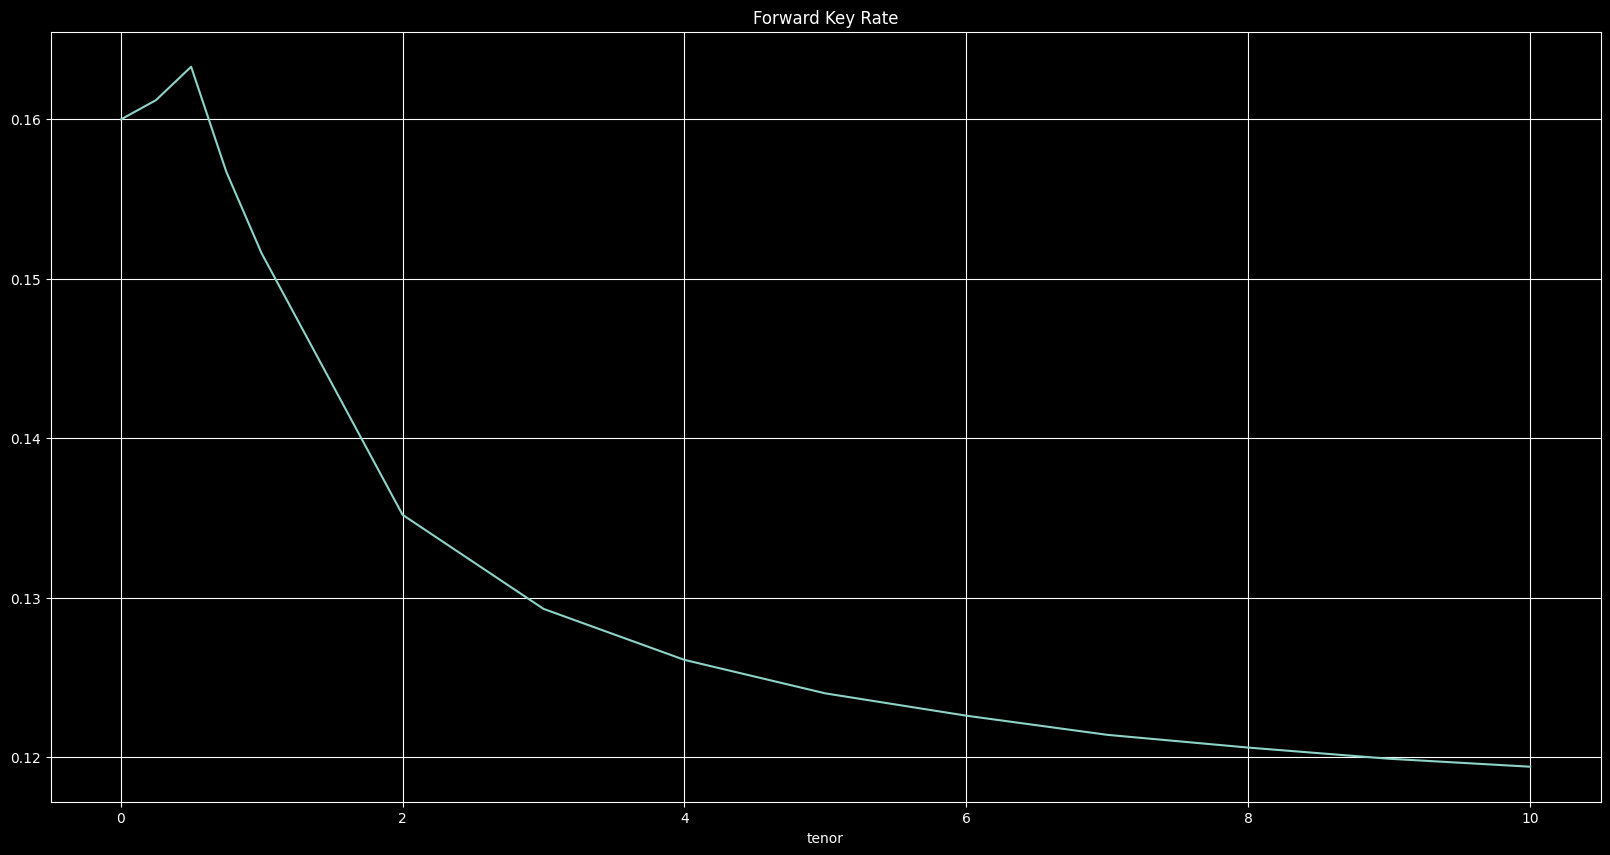

In [63]:
fwd_key_rate.set_index('tenor').sort_index().forward_rate.plot(title='Forward Key Rate', grid=True, figsize=(20,10));

In [64]:
# Create 3D surface plot using Plotly
fig = plot_volatility_surface(
    vol_key_rate,
    value_column='implied_normal_vol',
    title='Implied Normal Volatility Surface',
    z_axis_title='Implied Normal Volatility'
)
fig.show()

In [65]:
key_rate_fwd_curve = build_fwd_curve(
    torch.tensor(fwd_key_rate.forward_rate.values),
    torch.tensor(fwd_key_rate.time_to_maturity.values)
)

In [66]:
vol_key_rate['pv'] = caplet_premium_from_now_starting(vol_key_rate, key_rate_fwd_curve, ois_yield_curve).numpy()

In [67]:
# Create 3D surface plot for present values
fig = plot_volatility_surface(
    vol_key_rate,
    value_column='pv',
    title='Present Value Surface',
    z_axis_title='Present Value'
)
fig.show()

### 1.4 Short Rate Models
#### 1.4.1 Hull-White

Dynamics in bank account numeraire risk-neutral measure $Q$ are given by:
$$
dr_t = \left( \theta_t - \lambda r_t \right) dt + \sigma dW_t
$$

with $\theta_t$ fixed by the HJM no-arbitrage condition. This can be rewritten as affine process:

$$
r_t = \alpha_t + x_t 
$$

where the deterministic part follows the HJM condition:
$$
\alpha_T = \frac{\partial}{ \partial T}\log P_{t,T} - \frac{\partial}{ \partial T} \log \mathbb{E}^Q_t \left[ \exp \left(- \int_{t}^T x_u du \right) \right]
$$
and the stochastic part:
$$
dx_t = - \lambda x_t dt + \sigma dW_t
$$
which is simply a Gaussian:
$$
x_T \sim \mathcal{N} \left( x_t e^{-\lambda(T-t)}, \quad \frac{\sigma^2}{2 \lambda} \left( 1- e^{-2\lambda (T-t)} \right) \right)
$$

Changing to the $T$-forward measure $Q^T$: 
$$
dx_t = - \left( \frac{\sigma^2}{\lambda} \left(1 - e^{-\lambda(T-t)} \right) + \lambda x_t \right) dt + \sigma dW^T_t
$$

which is also a Gaussian with mean:
$$
\mathbb{E}^{Q^T}_{t} \left[ x_{t+\Delta} \right] = x_t e^{-\lambda \Delta} - \frac{\sigma^2}{\lambda^2} \left(1 - e^{-\lambda \Delta} \right) - \frac{\sigma^2}{2\lambda^2} \left(e^{-\lambda(T-t-\Delta)} - e^{-\lambda(T-t+\Delta)} \right) 
$$
and variance $\frac{\sigma^2}{2 \lambda} \left( 1- e^{-2\lambda \Delta} \right)$ as in measure $Q$.

In bank account numeraire we price caplets: 

$$
V^{\text{Caplet}}_t \left[ R_{t,T}, K \right] = B_t \mathbb{E}_{t}^Q \left[  \left( \exp \left( \int_{T - \tau}^T r_u du \right)  - 1 - \tau K \right)^+  / B_T\right] 
$$
and arithmetic average payoff:
$$
V^{\text{Caplet}}_t \left[ A_{t,T}, K \right] = B_t \mathbb{E}_{t}^{Q} \left[ \left( \int_{T - \tau}^T r_u du - \tau K \right)^+ / B_T\right] 
$$

or similarly any other backward looking payoff.

We are assuming $r_0$ is equal to the overnight forward rate (as data is incomplete)

In [68]:
r0 = torch.tensor(fwd_ois.forward_rate.values[0])
timeline = torch.linspace(0, 10., 3651) # 10 years Actual/365 day

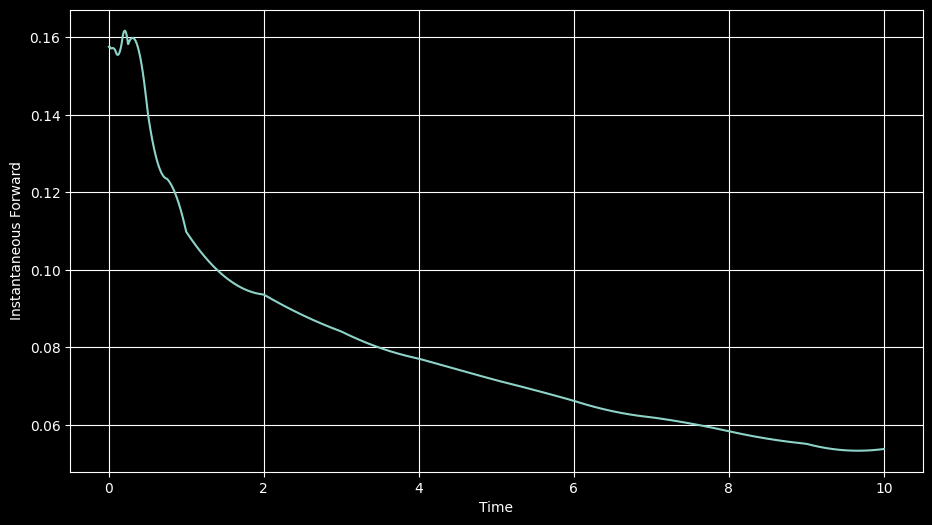

In [69]:
ois_ifwd_curve = build_ifwd_curve_from_now_starting(
    torch.tensor(fwd_ois.forward_rate.values),
    torch.tensor(fwd_ois.tenor.values)
)

plt.figure(figsize=(11, 6))
plt.plot(timeline[1:],ois_ifwd_curve.derivative(timeline[1:]).detach().numpy())
plt.ylabel('Instantaneous Forward')
plt.xlabel('Time')
plt.grid()
plt.show()

In [70]:
x0 = torch.tensor(0.) #, requires_grad = True)
lam = torch.tensor(2) #, requires_grad = True)
sigma = torch.tensor(0.3) #, requires_grad = True) 
model_hw = create_hull_white_model(timeline, 1000, ois_ifwd_curve, r0, x0, lam, sigma)

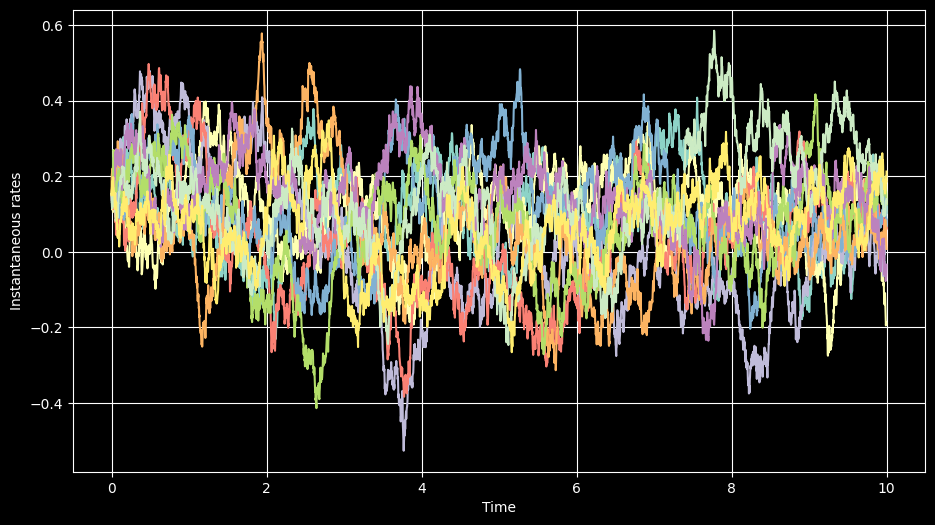

In [76]:
plt.figure(figsize=(11, 6))
plt.plot(timeline, model_hw.r_paths.T[:,:10])
plt.ylabel('Instantaneous rates')
plt.xlabel('Time')
plt.grid()
plt.show()

In [72]:
pv_hw_values = []
for _, row in vol_key_rate.iterrows():
    K = torch.tensor(row['strike'])
    T = torch.tensor(row['time_to_maturity'])
    pv_hw = price_now_starting_avg_caplet(K, T, model_hw)
    pv_hw_values.append(pv_hw.item())
vol_key_rate['pv_hw'] = pv_hw_values


In [73]:
fig = plot_volatility_surface(
    vol_key_rate, 
    ['pv', 'pv_hw'],
    colorscale=['Viridis', 'Plasma'],
    opacity=[1.0, 0.7]  # Second surface more transparent
)
fig.show()

In [74]:
def test_risk_neutrality(model, ois_yield_curve, asof_lambda, n_branch):
    model_2y = asof_lambda(torch.tensor(2.), n_branch, model)
    model_5y = asof_lambda(torch.tensor(5.), n_branch, model)

    plt.figure(figsize=(11, 6))
    
    plt.plot(
        model.timeline[1:], 
        zcb_yields(timeline[0], timeline[1:], model.ois_zcbs.detach()))
    
    plt.plot(
        model.timeline[1:], 
        zcb_yields(timeline[0], timeline[1:], ois_yield_curve.evaluate(timeline[1:])))
    
    plt.plot(
        model_2y.timeline[1:], 
        zcb_yields(model_2y.timeline[0], model_2y.timeline[1:], model_2y.ois_zcbs).T[:,:5]
    )
    plt.plot(
        model_5y.timeline[1:], 
        zcb_yields(model_5y.timeline[0], model_5y.timeline[1:], model_5y.ois_zcbs).T[:,:5]
    )
    
    plt.ylabel('Yield curve')
    plt.xlabel('Time')
    plt.grid()
    plt.show()

    id_4y = id_from_years(4, model.timeline)
    P_4y = model.ois_zcbs[id_4y]
    id_2y = id_from_years(2, model.timeline)
    inv_B_2y = torch.exp(-model.sum_r_dt[:, id_2y])
    id_2y_4y = id_from_years(4, model_2y.timeline)
    P_2y_4y = model_2y.ois_zcbs[:,id_2y_4y]
    mP_4y = torch.mean(inv_B_2y * P_2y_4y)
    print(f'P(0,4y) = {P_4y} ~ {mP_4y} = E[P(2y, 4y) / B_2y]')

    id_7y = id_from_years(7, model.timeline)
    P_7y = model.ois_zcbs[id_7y]
    id_5y = id_from_years(5, model.timeline)
    inv_B_5y = torch.exp(-model.sum_r_dt[:, id_5y])
    id_5y_7y = id_from_years(7, model_5y.timeline)
    P_5y_7y = model_5y.ois_zcbs[:,id_5y_7y]
    mP_7y = torch.mean(inv_B_5y * P_5y_7y)
    print(f'P(0,7y) = {P_7y} ~ {mP_7y} = E[P(5y, 7y) / B_5y]')

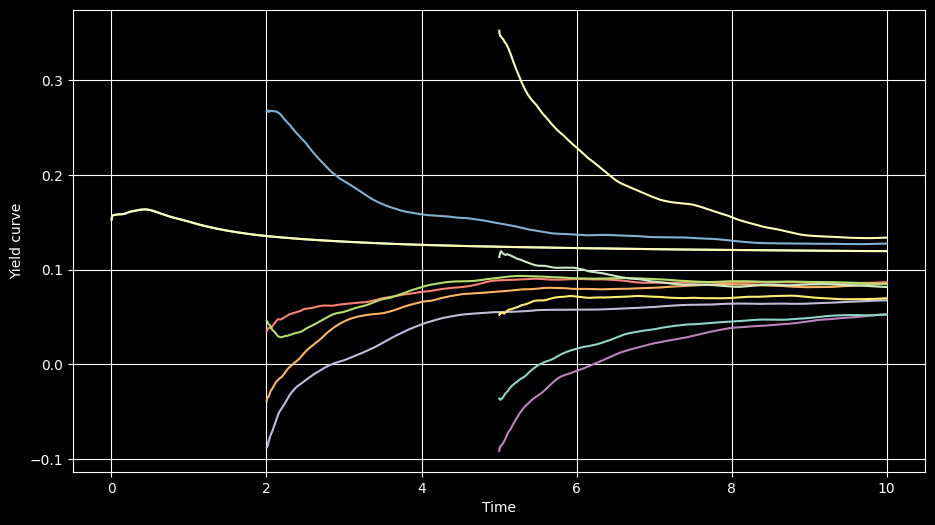

P(0,4y) = 0.6647138595581055 ~ 0.6620354652404785 = E[P(2y, 4y) / B_2y]
P(0,7y) = 0.5404692888259888 ~ 0.542015790939331 = E[P(5y, 7y) / B_5y]


In [77]:
test_risk_neutrality(model_hw, ois_yield_curve, hull_white_model_asof, 100)

#### 1.4.1 The Hull-White-Heston model

To price the volatility smile we rely on stochastic volatility models such as the Heston Model, which combined with Hull-White looks like:

$$
\left\{
\begin{array}{l}
    dx_t = - \lambda x_t dt + \sqrt{v_t} \text{d}W_t^x,  \\
    dv_t =  \kappa (\theta(t) - v_t)dt + \varepsilon(t) \sqrt{v_t} \text{d} W_t^v,
\end{array}\right.
$$
with $\theta(t)$ and $\varepsilon(t)$ local volatility functions. Note no correlation between the Brownian motions $dW_t^x \cdot dW_t^v = 0$, as this breaks the affinity of the process when changing from measure $Q$ to the $T$-forward $Q^T$: 
$$
\left\{
\begin{array}{l}
    dx_t =  - \left( \frac{v}{\lambda} \left(1 - e^{-\lambda(T-t)} \right) + \lambda x_t \right) dt + \sqrt{v_t} \text{d}W_t^x,  \\
    dv_t =  \kappa (\theta - v_t)\text{d}t + \varepsilon \sqrt{v_t} \text{d} W_t^v,
\end{array}\right.
$$

The short rate itself:
$$ 
r_t = \alpha_t + x_t 
$$ 
where the HJM condition on $\alpha_t$ is described in the multiple-curve framework below.

Stochastic variance is an CIR process with non-central chi-squared distribution:
$$
\mathbb{P}\left(v_{t + \Delta}<v \mid v_{t}\right) \quad = \quad F_{\chi'^{2}}\left(\frac{4 \kappa v}{\varepsilon(t)^{2}\left(1-e^{-\kappa \Delta}\right)} ; \frac{4 \kappa \theta(t)}{\varepsilon(t)^{2}}, \frac{4 v_{t} \kappa e^{-\kappa \Delta}}{\varepsilon(t)^{2}\left(1-e^{-\kappa \Delta}\right)}\right) \quad
$$
over a time step $\Delta$, and admits an almost exact QE simulation scheme.  

Since no correlation leaks can occur, the Euler scheme is sufficient to evolve $x_t$ and $v_t$:
$$
x_{t+\Delta} \sim \mathcal{N} \left( x_t e^{-\lambda \Delta}, \quad \frac{v_t}{2 \lambda} \left( 1- e^{-2\lambda \Delta} \right) \right)
$$
and similarly in $T$-forward measure.


In [78]:
v0 = torch.tensor(0.05) #, requires_grad = True)
kappa = torch.tensor(0.01) #, requires_grad = True) 

time_to_maturities = torch.tensor([0., 1., 2., 4., 8., 10.])
theta_values = torch.zeros_like(time_to_maturities)
theta_values[0] = 0.
theta_values[1] = 0.
theta_values[2] = 0.
theta_values[3] = 1
theta_values[4] = 2
theta_values[5] = 3


eps_values = torch.zeros_like(time_to_maturities)
eps_values[0] = 0.
eps_values[1] = 0.
eps_values[2] = 0.
eps_values[3] = 0.1
eps_values[4] = 0.2
eps_values[5] = 0.3


# Evaluate over timeline using PCHIP interpolation (inside optimization loop)
theta = evaluate_timeline(timeline, time_to_maturities, theta_values)
epsilon = evaluate_timeline(timeline, time_to_maturities, eps_values)

In [79]:
model_hwh = create_hull_white_heston_model(timeline, 10000, ois_ifwd_curve, r0, x0, lam, v0, kappa, theta, epsilon)

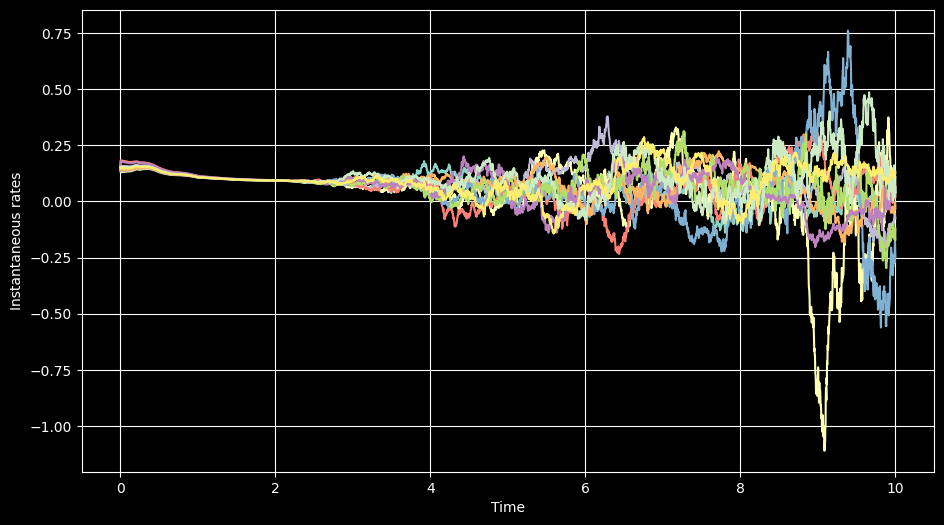

In [80]:
plt.figure(figsize=(11, 6))
plt.plot(timeline, model_hwh.r_paths.T[:,:10])
plt.ylabel('Instantaneous rates')
plt.xlabel('Time')
plt.grid()
plt.show()

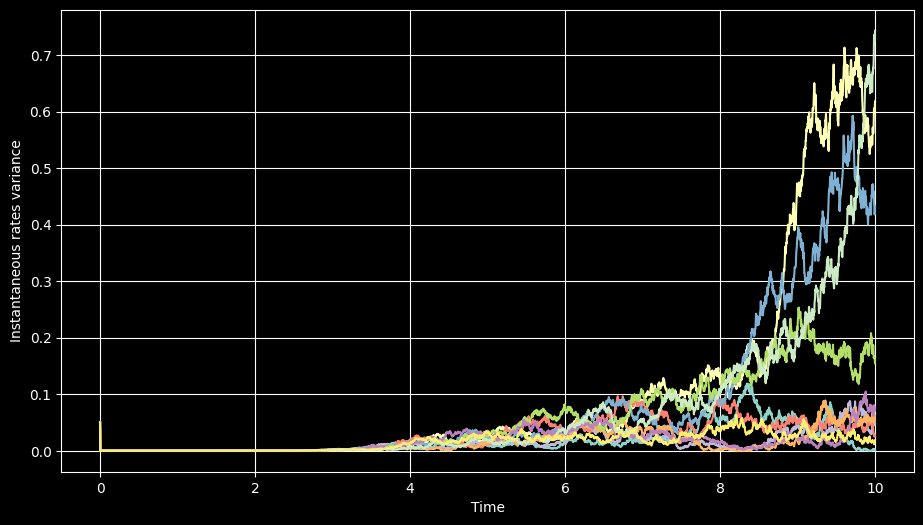

In [81]:
plt.figure(figsize=(11, 6))
plt.plot(timeline, model_hwh.v_paths.T[:,:10])
plt.ylabel('Instantaneous rates variance')
plt.xlabel('Time')
plt.grid()
plt.show()

In [82]:
pv_hwh_values = []
for _, row in vol_key_rate.iterrows():
    K = torch.tensor(row['strike'])
    T = torch.tensor(row['time_to_maturity'])
    pv_hwh = price_now_starting_avg_caplet(K, T, model_hwh)
    pv_hwh_values.append(pv_hwh.item())
vol_key_rate['pv_hwh'] = pv_hwh_values

In [83]:
fig = plot_volatility_surface(
    vol_key_rate, 
    ['pv', 'pv_hwh'],
    colorscale=['Viridis', 'Plasma'],
    opacity=[1.0, 0.7]  # Second surface more transparent
)
fig.show()

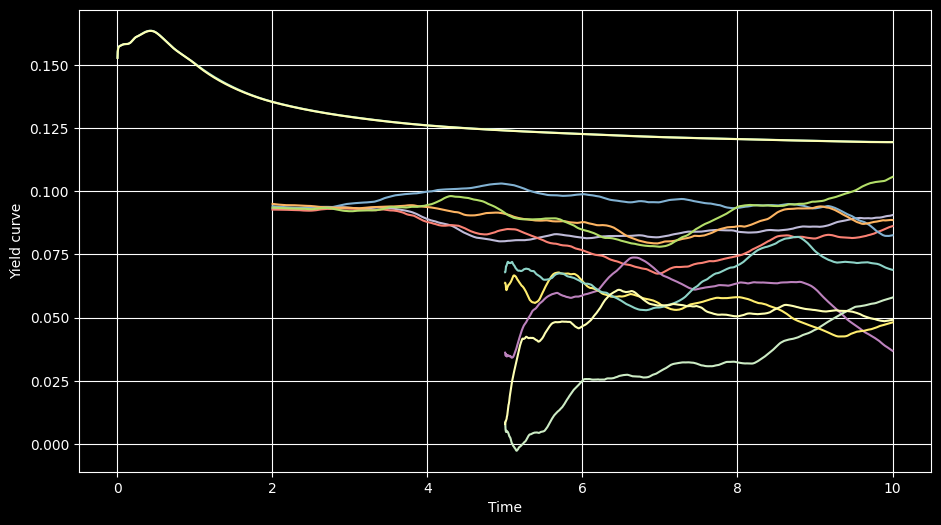

P(0,4y) = 0.6646655201911926 ~ 0.6644810438156128 = E[P(2y, 4y) / B_2y]
P(0,7y) = 0.5404297113418579 ~ 0.5400910377502441 = E[P(5y, 7y) / B_5y]


In [84]:
test_risk_neutrality(model_hwh, ois_yield_curve, hull_white_heston_model_asof, 10)

## 2. Multi-Curve models

### 2.1 Affine multi-curve models and IBOR rates

The short rate is given by:
$$
r_t = f(t) + \lambda^T \textbf{x}_t
$$
where $\textbf{x}_t$ is an affine process and $\lambda$ is constant. The latter drive also the instantaneous forward spread rates to other curves:
$$
s_t^{\delta} = s^{\delta}(t) + \gamma_{\delta}^T \textbf{x}_t
$$
enumerated by $\delta$, with $\gamma_{\delta}$ constant. If those spreads corresponds to IBOR rates, then $\delta$ are the tenors, and we require:
$$
0 \leq s_t^{\delta_i}  \leq s_t^{\delta_j}, \quad  \delta_i < \delta_j
$$
in which case we can calibrate to the available ZCB curves:
$$
T \rightarrow P_{t,T} = \mathbb{E}_t \left[ e^{- \int_{t,T} r_u du} \right], \quad P^\delta_{t,T} = \mathbb{E}_t \left[ e^{ - \int_{t,T} \left(r_u + s^{\delta}_u \right)du} \right]
$$

where $P_{t,T}$ is the OIS curve, and the other correspond to IBOR forward rates at different tenors:
$$
L_t(T-\delta, T)=  \frac{P_{t,T-\delta}^\delta - P_{t,T}^\delta}{\delta \cdot P_{t,T}^\delta} 
$$

Denoting the forward spreads:
$$
S^{\delta}_t(T) = \frac{1 + \delta \cdot L_t(T-\delta, T)}{1 + \delta \cdot L^D_t(T-\delta,T)} = \frac{P_{t,T-\delta}^\delta}{P_{t,T}^\delta} \frac{P_{t,T}}{P_{t,T-\delta}}
$$
where $L^D_t(T-\delta, T) =   \frac{P_{t,T-\delta} - P_{t,T}}{\delta P_{t,T} }$ is the forward looking RFR.

We recall that the instantaneous forward is given by:
$$
f_{t,T} = - \frac{\partial}{\partial T} \log P_{t,T}
$$

whereas the instantenous multiplicative spread:
$$
s^{\delta}_{t,T} =  \frac{\partial}{\partial T} \log S^\delta_t(T)
$$

note the difference is signs, as heuristically the instantenous forward for the tenor-$\delta$ curve is  $f_{t,T}^\delta = f_{t,T} + s^{\delta}_{t,T}$.

The HJM condition in that case reduces to:
$$
f(t) = - f_{t,T} + \bar{f}_{t,T}, \quad s^{\delta}(t) = - \frac{\partial}{\partial t} \log S^\delta _0(t) + \frac{\partial}{\partial t} \log \bar{S}^\delta _0(t) 
$$
where the base curves $\bar{P}_{0,t}$ and $\bar{S}^\delta _0(t)$ are obtained from a model where $f(t)\equiv 0$ and $s^{\delta}(t) \equiv 0$.


#### 2.1.1 Linear Products

IBOR quotes typically come from FRAs, whose present value at strike $K$ is given by:
$$
PV_t\left[K \right] = P_{t,T} S^{\delta}_t(T)- (1 + \delta K) P_{t, T+\delta}
$$

Using IRSs quotes, one solves for forward spreads $S^{\delta}_t(T)$ directly, as the former evaluates to:
$$
PV_t \left[\delta,  \delta', K\right] = \sum_{i \geq 1} \left( P_{t, T_{j-1}}  S^{\delta}_t(T_{j-1}) -  P_{t, T_{j}} \right) - \delta' K \sum_{j\geq 1} P_{t, T'_j}
$$
where $\delta = T_{i} - T_{i-1}$ is the floating leg tenor and $\delta' = T'_{j} - T'_{j-1}$ is the fixed leg tenor. 

#### 2.1.2 Model with CIR processes
A typical example can be obtained using self-exciting CIR processes for the forward spreads and Hull White dynamics for the rate:
$$
s_t^{\delta_j} = s^{\delta_j}(t) + \sum_{i \leq j} \gamma_i x_{t}^i, \quad \gamma_i \geq 0, \quad dx_{t}^i= \kappa_i (\theta_i - x_{t}^i) dt + \epsilon_i \sqrt{x_{t}^i} dW_t^i
$$
where tenors $\delta_{1} < \delta_{2} < \dots < \delta_{n}$ are in increasing order. 

The short rate  follows the Hull-White-Heston multi-factor model:
$$
r_t = f(t) + x_t^0, \quad dx_{t}^0 = - \lambda_0 x_{t}^0 dt + \sum_{i=1}^n \lambda_i \sqrt{x_{t}^i} dW_t^i
$$
where $\lambda_1^2 + \dots + \lambda_n^2 =1$, and all Brownian motions $W_t^i$ are independent.


### 2.2 Modelling Arithmetic-Average Compounding on a Key Rate

We are not confined to model IBOR rates with spreads $s_t^{\delta}$. In fact, we can choose any other curve, in which case we will need to fit whatever market quotes are available to us. 

In our case, we have a forward curve for arithmetic-average backward looking $A_{t,T}$ on a Key Rate, which is different from the OIS $r_t$ for which we also have forward curve. And we need to capture the smile of a volatility surface on $A_{t,T}$. 

We can add to the Hull-White-Heston model a stochastic spread between OIS short rate and the Key Rate:
$$
r_t = f(t) + x_t, \quad dx_{t} = - \lambda x_{t} dt + \sqrt{v_t} dW_t^x, \quad dv_t =  \kappa (\theta - v_t)dt + \varepsilon \sqrt{v_t} dW_t^v
$$
as above and the spread follows a mean-reversion processess near zero:
$$
s_t = s^a(t) + k_t, \quad dk_t =  - \gamma k_t dt + \xi dW_t^k
$$
with all Brownian motions $W_t^x, W_t^v$ and $W_t^k$ independent. 

Note that the spread $s^a(t)$ does not depend on a tenor $\tau$ as we are working with RFR rates, and therefore can be computed from any tenor. The most convenient is the one corresponding to time to maturity $\tau = T-t$, and in fact it is the one which is typically quoted. In that case:
$$
s^a(t) = - \left( f_{t,T}^a - f_{t,T} \right) + \left( \bar{f}_{t,T}^a - \bar{f}_{t,T} \right)
$$
where the top-bar terms are the ones obtained from the model with $s^a(t) \equiv 0$ and $f(t) \equiv 0$ as above.

Ignoring the convexity correction, obtain the Key Rate instantaneous rates $f^a_{t,T}$ from:

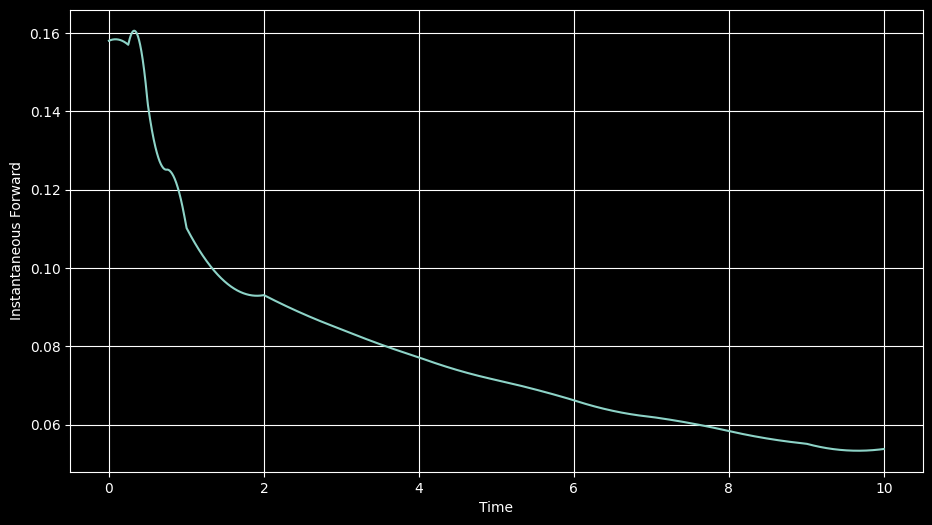

In [85]:

key_ifwd_values = torch.tensor(fwd_key_rate.forward_rate.values)
key_ifwd_curve = build_ifwd_key_curve_from_now_starting(
    key_ifwd_values, torch.tensor(fwd_key_rate.forward_rate.values), torch.tensor(fwd_key_rate.tenor.values))

plt.figure(figsize=(11, 6))
plt.plot(timeline,key_ifwd_curve.derivative(timeline).detach().numpy())
plt.ylabel('Instantaneous Forward')
plt.xlabel('Time')
plt.grid()
plt.show()

Obtain the parameters for the factors $x_t$, $v_t$ and $k_t$ as to fit the Caplet prices:
$$
V^{\text{Caplet}}_t \left[ A_{t,T}, K \right] = B_t \mathbb{E}_{t}^{Q} \left[ \left( \int_{T - \tau}^T r_u + s_udu - \tau K \right)^+ / B_T\right] 
$$
from

and the Key Rate forwards using:
$$
A_{t,T} = \mathbb{E}^{Q^T}_{t} \left[ \frac{1}{\tau} \int_{T - \tau}^T r_u + s_u du \right] = \frac{ \mathbb{E}_{t}^{Q} \left[ \frac{1}{\tau} \int_{T - \tau}^T r_u + s_u du / B_T \right] }{\mathbb{E}_{t}^{Q} \left[ 1/B_T \right]}
$$
via Monte-Carlo.

In [86]:
k0 = torch.tensor(0.)
gamma = torch.tensor(0.01)
xi = torch.tensor(0.01)

In [87]:
a0 = r0 + k0
model_key = create_key_rate_model(timeline, 10000, key_ifwd_curve, ois_ifwd_curve, r0, a0, v0, kappa, theta, epsilon, x0, lam, k0, gamma, xi )

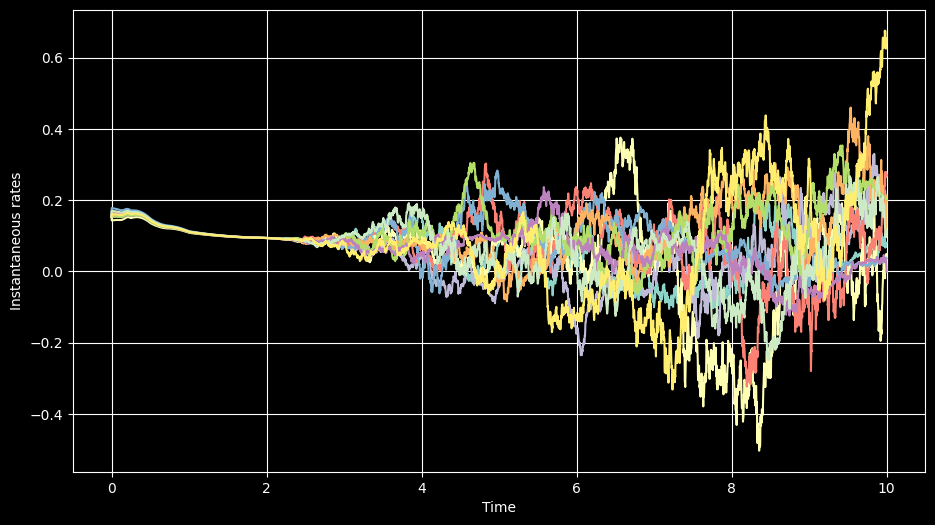

In [88]:
plt.figure(figsize=(11, 6))
plt.plot(timeline, model_key.r_paths.T[:,:10])
plt.ylabel('Instantaneous rates')
plt.xlabel('Time')
plt.grid()
plt.show()

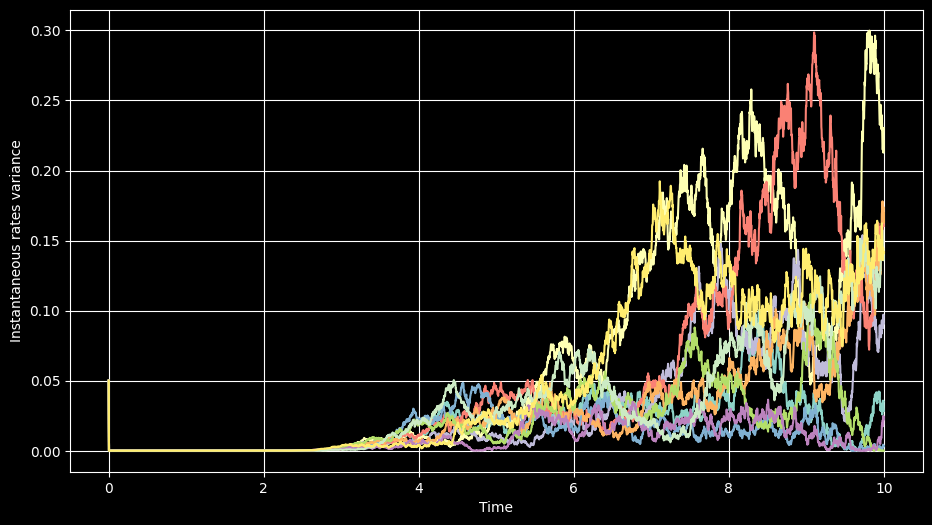

In [89]:
plt.figure(figsize=(11, 6))
plt.plot(timeline, model_key.v_paths.T[:,:10])
plt.ylabel('Instantaneous rates variance')
plt.xlabel('Time')
plt.grid()
plt.show()

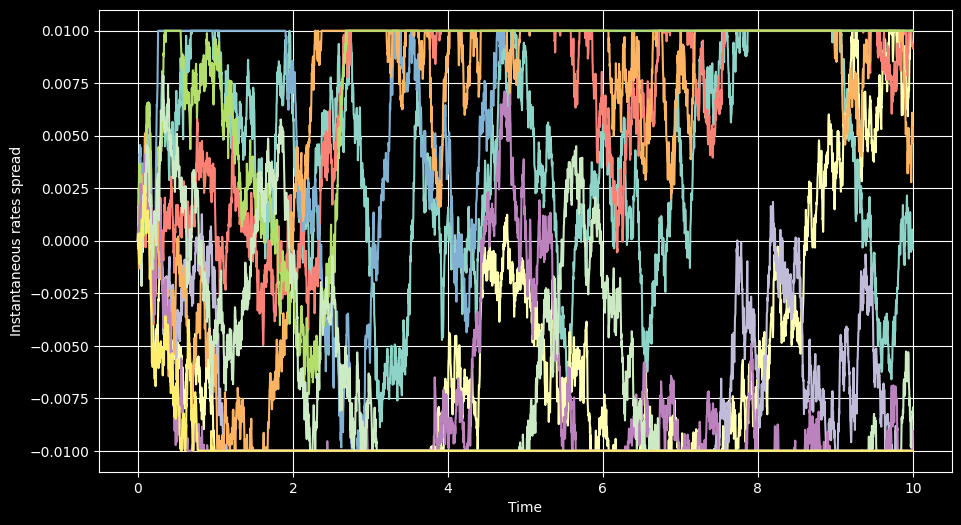

In [90]:
plt.figure(figsize=(11, 6))
plt.plot(timeline, model_key.s_paths.T[:,:10])
plt.ylabel('Instantaneous rates spread')
plt.xlabel('Time')
plt.grid()
plt.show()

In [91]:
model_key.s_curve

tensor([0.0000, 0.0005, 0.0004,  ..., 0.0052, 0.0052, 0.0053])

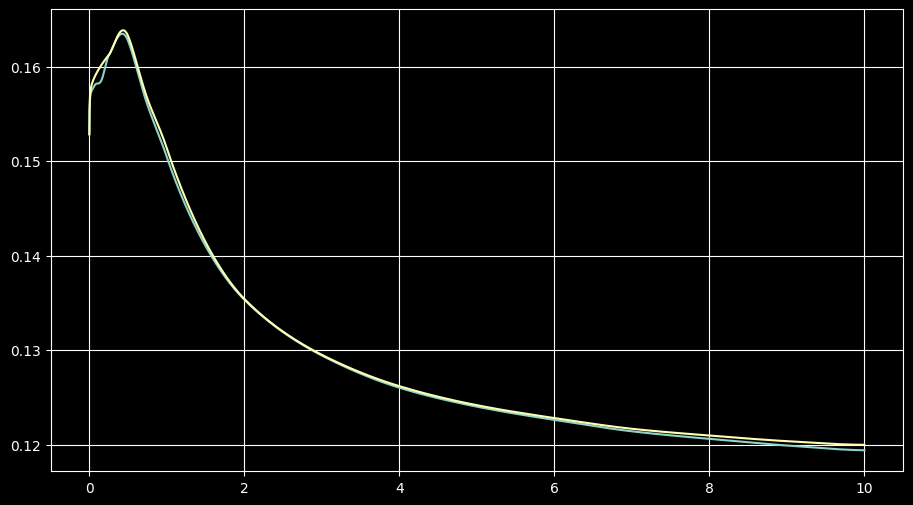

In [92]:
plt.figure(figsize=(11, 6))  
plt.plot(
    model_key.timeline[1:], 
    zcb_yields(timeline[0], timeline[1:], model_key.ois_zcbs.detach()))
plt.plot(
    model_key.timeline[1:], 
    zcb_yields(timeline[0], timeline[1:], model_key.key_zcbs.detach()))

plt.grid()
plt.show()

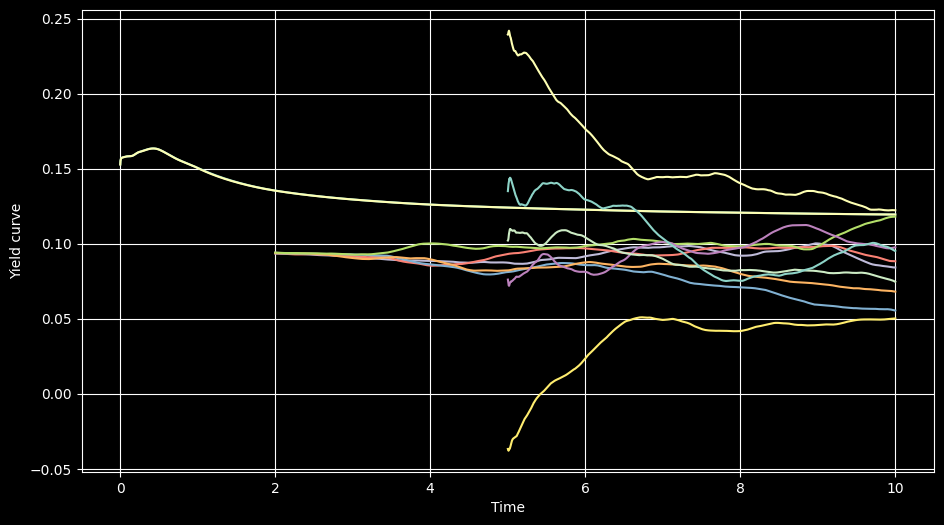

P(0,4y) = 0.6646749973297119 ~ 0.6645669341087341 = E[P(2y, 4y) / B_2y]
P(0,7y) = 0.5404368042945862 ~ 0.5409023761749268 = E[P(5y, 7y) / B_5y]


In [93]:
test_risk_neutrality(model_key, ois_yield_curve, key_rate_model_asof, 10)

In [94]:
price_key_caplet_surface(model_key, vol_key_rate, fwd_key_rate)

(tensor(1.5837, dtype=torch.float64), tensor(0.0093, dtype=torch.float64))

In [95]:
fig = plot_volatility_surface(
    vol_key_rate, 
    ['pv', 'pv_model_key'],
    colorscale=['Viridis', 'Plasma'],
    opacity=[1.0, 0.7]  # Second surface more transparent
)
fig.show()

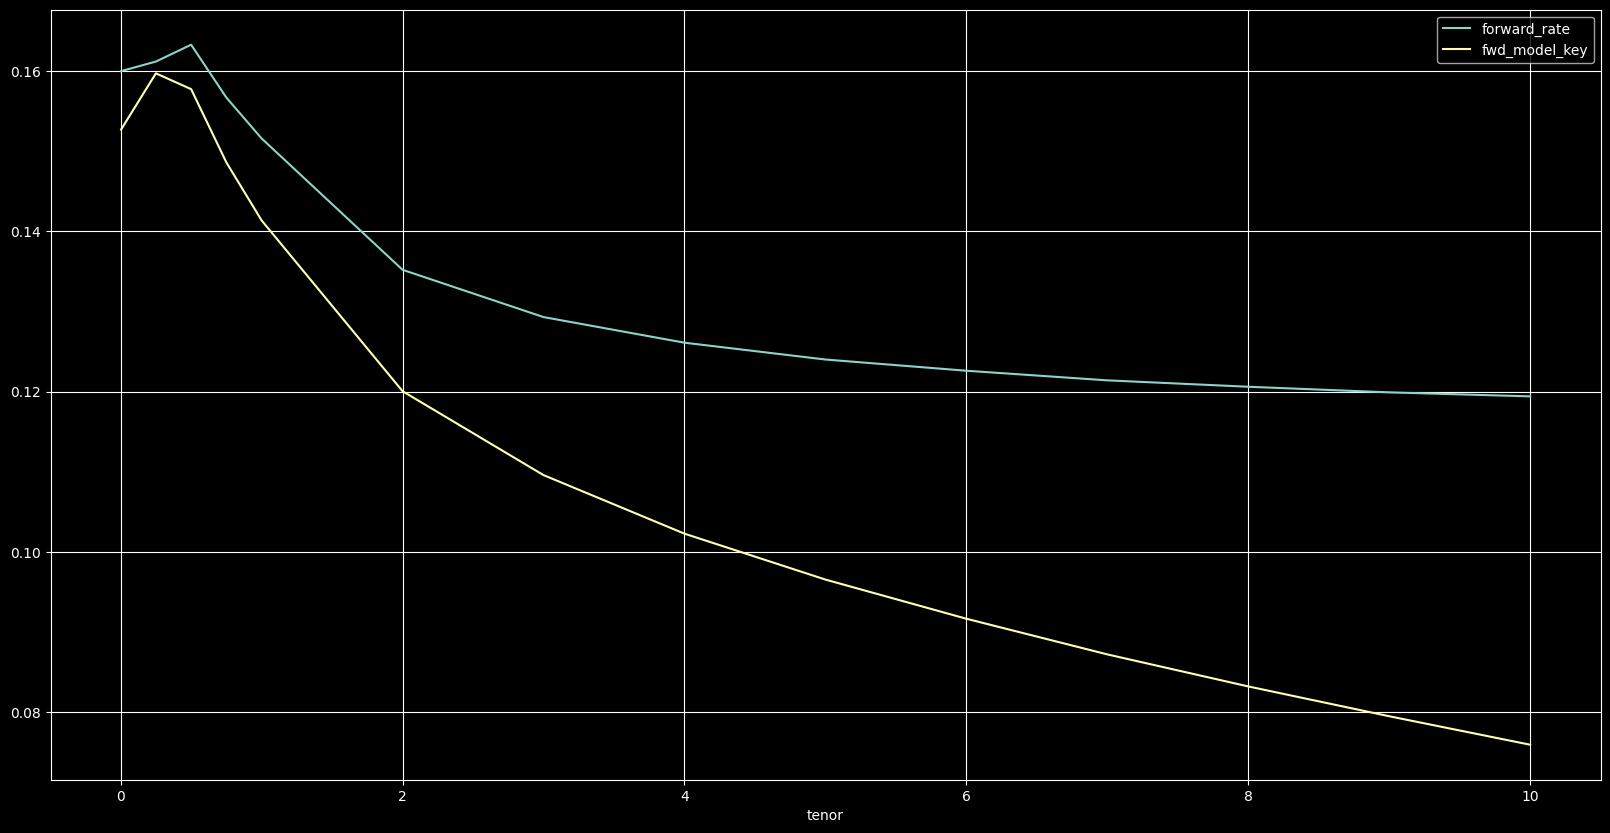

In [96]:
fwd_key_rate.set_index('tenor')[['forward_rate', 'fwd_model_key']].plot(legend=True, grid=True, figsize=(20,10));

The model needs to calibrate for both the vol surface and forward rate. 

## 3 Product examples

### 3.1 Swaptions

A physically-settled payer (+) or receiver (-) swaption at the start $T_0$ of the IRS swap expires with value:
$$
PV_{T_0} = \text{PVBP}(T_0) \left(\pm \left( S_{T_0} - K\right)\right)^+
$$
where the present value of basis point $\text{PVBP}(T_0) =  \delta' \sum_{i > 0} P_{T_0, T_i}$ is computed from the risk free OIS curve and the swap rate $S_{T_0}$ comes from the floating rate that might be backward looking or IBOR based.

Using $\text{PVBP}(t)$ as numeraire we can price the swaption:
$$
PV_t = \text{PVBP}(t) \cdot \mathbb{E}_{t}^{\text{PVBP}} \left[(\pm\left( S_{T_0} - K)\right)^+ \right] 
$$
in which the swap rate $S_t$ is naturally a martingale.

For cash-settled swaptions, the payoff is settled at $T_0$ according to the formula:
$$
PV_{T_0} = \text{Ann}(S_{T_0}) \left(\pm  \left( S_{T_0} - K\right) \right)^+, \quad \text{Ann}(s) =\sum_{i > 0} \frac{ \delta' }{(1 + \delta' s)^i }
$$

Market makers formula convention simply substitutes cash-annuity Ann for PVBP in the physically-settled case:
$$
PV_t = P_{t,T_0}  \text{Ann}(S_t) \cdot \mathbb{E}_{t}^{\text{PVBP}} \left[(\pm\left( S_{T_0} - K)\right)^+ \right], \quad S_t = \mathbb{E}_{t}^{\text{PVBP}} [S_{T_0}]
$$
which leads to a failure of put-call parity, especially when we are in IBOR multi-curve environment.

To account for the convexity correction needed, one introduces the cash-settled convexity adjusted PVBP:
$$
\text{CSCAP}(t) = B_t \cdot \mathbb{E}^Q_{t} \left[ \frac{\text{Ann}(T_0) }{B_{T_0}}  \right]
$$
and the cash-settled convexity adjusted forward:
$$
\text{CSCAF}(t) = \frac{B_t}{\text{CSCAP}(t)} \cdot \mathbb{E}^Q_{t} \left[ S_{T_0}\frac{\text{Ann}(T_0) }{B_{T_0}}  \right]
$$

In that case, we do obtain the desired put-call parity:
$$
PV_t\left[\text{payer}, K \right] - PV_t\left[\text{receiver}, K \right] = \text{CSCAP}(t) \cdot \left( \text{CSCAF}(t) - K \right)
$$


#### Exercise 3.1.1
Price via Monte-Carlo using the model from 2.2.1 a Physically-Settled ATM payer swaption with maturity 1Y for a 3M3Y IRS swap. Price via Monte-Carlo a Cash-Settled swaption with the same strike together with the convexity corrected forward CSCAP and annuity CSCAF.

In [103]:
T_0 = 1.0          
T_start = 1.25      
T_end = 4.25       
payment_dates = [1.25, 2.25, 3.25, 4.25]  
n_payments = len(payment_dates)
delta = 1.0         # Day count fraction (annual)

n_paths_swaption = 5000
n_branch_swaption = 50

print("Swaption Parameters:")
print(f"  Expiry T_0 = {T_0}Y")
print(f"  Swap: {T_start}Y to {T_end}Y ({T_end - T_start}Y tenor)")
print(f"  Payment dates: {payment_dates}")
print(f"  n_paths = {n_paths_swaption}, n_branches = {n_branch_swaption}")
print()

# Step 1: Compute ATM Strike from Forward Curve
# Forward swap rate S_0 = (P_0,Tstart - P_0,Tend) / PVBP_0
# PVBP_0 = delta * sum(P_0,Ti)

P_0_start = ois_yield_curve.evaluate(torch.tensor(T_start)).item()
P_0_end = ois_yield_curve.evaluate(torch.tensor(T_end)).item()

PVBP_0 = 0.0
for T_i in payment_dates:
    PVBP_0 += delta * ois_yield_curve.evaluate(torch.tensor(T_i)).item()

K_atm = (P_0_start - P_0_end) / PVBP_0

print("ATM Strike Calculation:")
print(f"  P(0, {T_start}Y) = {P_0_start:.6f}")
print(f"  P(0, {T_end}Y) = {P_0_end:.6f}")
print(f"  PVBP(0) = {PVBP_0:.6f}")
print(f"  ATM Strike K = {K_atm:.4%}")
print()

# Step 2: Create Model and Simulate to T_0
# Use Hull-White model for OIS rate
# Extend timeline to cover T_end = 4.25Y

timeline_swaption = torch.linspace(0., 5., 2501)  # 5Y with daily steps

print("Creating Hull-White model for OIS...")
model_swaption = create_hull_white_model(
    timeline_swaption, n_paths_swaption, 
    ois_ifwd_curve, r0, x0, lam, sigma
)

# Step 3: Branch at T_0 and Compute ZCBs
print(f"Branching at T_0 = {T_0}Y...")

T_0_tensor = torch.tensor(T_0)
branched = hull_white_model_asof(T_0_tensor, n_branch_swaption, model_swaption)

# Get discount factor from 0 to T_0
idx_T0 = id_from_years(T_0_tensor, model_swaption.timeline)
discount_0_T0 = torch.exp(-model_swaption.sum_r_dt[:, idx_T0 - 1])

# Get ZCBs P_{T_0, T_i} for each payment date
# branched.ois_zcbs has shape (n_paths, n_steps) - already averaged over branches
zcb_T0 = {}
for T_i in [T_start] + payment_dates:
    idx = id_from_years(torch.tensor(T_i), branched.timeline)
    zcb_T0[T_i] = branched.ois_zcbs[:, idx - 1]
    print(f"  P(T_0, {T_i}Y) mean = {zcb_T0[T_i].mean():.6f}")

# Step 4: Compute Swap Rate S_{T_0} and PVBP(T_0)
# PVBP(T_0) = delta * sum(P_{T_0, T_i})
PVBP_T0 = torch.zeros(n_paths_swaption)
for T_i in payment_dates:
    PVBP_T0 += delta * zcb_T0[T_i]

# Swap rate: S = (P_{T_0, Tstart} - P_{T_0, Tend}) / PVBP
P_T0_start = zcb_T0[T_start]
P_T0_end = zcb_T0[T_end]

swap_rate_T0 = (P_T0_start - P_T0_end) / PVBP_T0

print()
print("Swap Rate at T_0:")
print(f"  Mean S_{{T_0}} = {swap_rate_T0.mean():.4%}")
print(f"  Std S_{{T_0}} = {swap_rate_T0.std():.4%}")
print(f"  Min = {swap_rate_T0.min():.4%}, Max = {swap_rate_T0.max():.4%}")

# Step 5: Cash Annuity Function
def cash_annuity(s, delta, n_payments):
    """
    Ann(s) = sum_{i=1}^{n} delta / (1 + delta*s)^i
    """
    ann = torch.zeros_like(s)
    for i in range(1, n_payments + 1):
        ann += delta / (1 + delta * s) ** i
    return ann

# Ann(S_{T_0}) for each path
ann_T0 = cash_annuity(swap_rate_T0, delta, n_payments)

print()
print("Cash Annuity at T_0:")
print(f"  Mean Ann(S_{{T_0}}) = {ann_T0.mean():.6f}")
print(f"  Std = {ann_T0.std():.6f}")

# Step 6: Physically-Settled Swaption (Payer)
# Payoff = PVBP(T_0) * (S_{T_0} - K)^+
payoff_phys = PVBP_T0 * torch.clamp(swap_rate_T0 - K_atm, min=0)

# PV = E[Payoff * D_{0,T_0}]
pv_phys = (payoff_phys * discount_0_T0).mean()
pv_phys_std = (payoff_phys * discount_0_T0).std() / (n_paths_swaption ** 0.5)

print()
print("=" * 42)
print("PHYSICALLY-SETTLED PAYER SWAPTION (ATM)")
print("=" * 42)
print(f"Strike K = {K_atm:.4%}")
print(f"PV = {pv_phys:.6f} +/- {1.96*pv_phys_std:.6f}")
print(f"ITM paths: {(swap_rate_T0 > K_atm).float().mean()*100:.1f}%")

# Step 7: Cash-Settled Swaption (Payer)
# Payoff = Ann(S_{T_0}) * (S_{T_0} - K)^+
payoff_cash = ann_T0 * torch.clamp(swap_rate_T0 - K_atm, min=0)

# PV = E[Payoff * D_{0,T_0}]
pv_cash = (payoff_cash * discount_0_T0).mean()
pv_cash_std = (payoff_cash * discount_0_T0).std() / (n_paths_swaption ** 0.5)

print()
print("=" * 42)
print("CASH-SETTLED PAYER SWAPTION (ATM)")
print("=" * 42)
print(f"Strike K = {K_atm:.4%}")
print(f"PV = {pv_cash:.6f} +/- {1.96*pv_cash_std:.6f}")

# Step 8: CSCAP and CSCAF (Convexity Corrections)
# CSCAP = E[Ann(S_{T_0}) * D_{0,T_0}]
cscap = (ann_T0 * discount_0_T0).mean()
cscap_std = (ann_T0 * discount_0_T0).std() / (n_paths_swaption ** 0.5)

# CSCAF = E[S_{T_0} * Ann(S_{T_0}) * D_{0,T_0}] / CSCAP
cscaf_numerator = (swap_rate_T0 * ann_T0 * discount_0_T0).mean()
cscaf = cscaf_numerator / cscap

print()
print("=" * 42)
print("CONVEXITY CORRECTIONS")
print("=" * 42)
print(f"CSCAP (Convexity-Adjusted PVBP) = {cscap:.6f} +/- {1.96*cscap_std:.6f}")
print(f"CSCAF (Convexity-Adjusted Forward) = {cscaf:.4%}")
print()
print("Comparison:")
print(f"  PVBP(0) = {PVBP_0:.6f} vs CSCAP = {cscap:.6f} (diff = {(cscap - PVBP_0):.6f})")
print(f"  S_0 = {K_atm:.4%} vs CSCAF = {cscaf:.4%} (diff = {(cscaf - K_atm)*10000:.2f} bp)")

# Step 9: Put-Call Parity Check
# For cash-settled: Payer - Receiver = CSCAP * (CSCAF - K)

# Receiver swaption payoff
payoff_receiver = ann_T0 * torch.clamp(K_atm - swap_rate_T0, min=0)
pv_receiver = (payoff_receiver * discount_0_T0).mean()

# Put-Call Parity
parity_lhs = pv_cash - pv_receiver
parity_rhs = cscap * (cscaf - K_atm)

print()
print("=" * 42)
print("PUT-CALL PARITY CHECK")
print("=" * 42)
print(f"Payer PV = {pv_cash:.6f}")
print(f"Receiver PV = {pv_receiver:.6f}")
print(f"Payer - Receiver = {parity_lhs:.6f}")
print(f"CSCAP * (CSCAF - K) = {parity_rhs:.6f}")
print(f"Difference = {abs(parity_lhs - parity_rhs):.8f}")


print()
print("=" * 42)
print("SUMMARY: Physical vs Cash Settlement")
print("=" * 42)
print(f"{'Metric':<30} {'Physical':<15} {'Cash':<15}")
print("-" * 42)
print(f"{'PV Payer Swaption':<30} {pv_phys:<15.6f} {pv_cash:<15.6f}")
print(f"{'Annuity/PVBP at T_0 (mean)':<30} {PVBP_T0.mean():<15.6f} {ann_T0.mean():<15.6f}")
print(f"{'Difference (Cash - Phys)':<30} {'':<15} {(pv_cash - pv_phys):<15.6f}")


Swaption Parameters:
  Expiry T_0 = 1.0Y
  Swap: 1.25Y to 4.25Y (3.0Y tenor)
  Payment dates: [1.25, 2.25, 3.25, 4.25]
  n_paths = 5000, n_branches = 50

ATM Strike Calculation:
  P(0, 1.25Y) = 0.846627
  P(0, 4.25Y) = 0.652318
  PVBP(0) = 2.973617
  ATM Strike K = 6.5344%

Creating Hull-White model for OIS...
Branching at T_0 = 1.0Y...
  P(T_0, 1.25Y) mean = 0.972453
  P(T_0, 1.25Y) mean = 0.972453
  P(T_0, 2.25Y) mean = 0.880654
  P(T_0, 3.25Y) mean = 0.807843
  P(T_0, 4.25Y) mean = 0.745284

Swap Rate at T_0:
  Mean S_{T_0} = 6.7553%
  Std S_{T_0} = 1.4597%
  Min = 1.3743%, Max = 12.2889%

Cash Annuity at T_0:
  Mean Ann(S_{T_0}) = 3.409039
  Std = 0.112987

PHYSICALLY-SETTLED PAYER SWAPTION (ATM)
Strike K = 6.5344%
PV = 0.018234 +/- 0.000638
ITM paths: 56.5%

CASH-SETTLED PAYER SWAPTION (ATM)
Strike K = 6.5344%
PV = 0.018789 +/- 0.000665

CONVEXITY CORRECTIONS
CSCAP (Convexity-Adjusted PVBP) = 2.967714 +/- 0.009235
CSCAF (Convexity-Adjusted Forward) = 6.6403%

Comparison:
  PVBP(0)

#### 3.1.1 Conclusion
1. Mean swap rate (6.76%) is slightly higher than ATM K (6.53%), convexity effect probably takes place;
2. Cash-settled is 5.6bp more expensive than physical, convexity premium?;
3. CSCAF / CSCAP adjustments take place, Put-Call parity diff is ~0, so it seems that computation works OK.


### 3.2 Autocallable Caps and Floors

Given a term structure $T_0 < T_1 < \cdots < T_n$ and autocallable cap (+) or floor (-) pays at each date $T_i$, $i>0$ :
$$
\alpha \cdot \tau_i  \cdot \left( \pm \left( \mathcal{P}_{T_{i-1}, T_i} - K\right) \right)^+
$$

where $\mathcal{P}_{T_{i-1}, T_i}$ stands for a floating rate with tenor $\tau_i = T_i - T_{i-1}$ being an RFR rate (for example simple or arithmetic average daily compounding) or an IBOR rate. 

We also denote $\alpha$ the coupon rate, and $K$ the cap (resp. floor). 

The payment is conditional upon not reaching the autocallable barrier $\mathcal{P}_{T_{i-1}, T_i} < A$ (resp. $\mathcal{P}_{T_{i-1}, T_i} > A$ ), in which case the full notional is paid. At expiry date $T_n$, the notional is paid even if the barrier is not reached:
$$
\alpha \cdot \tau_n  \cdot \left( \pm \left( \mathcal{P}_{T_{n-1}, T_n} - K\right) \right)^+ + 1
$$

#### Exercise 3.2.1

Price via Monte-Carlo using the Key rate model an autocallable floor on the Key Rate starting now $T_0 = 0$ for 4 years $T_4 = 4$ with payments every year $T_i = i$ with coupon payments every year with strike $K = 0.15$, barrier $A = 0.13$, and coupon rate $\alpha = 0.165$.


In [53]:
# Looking at the data we see that:
# 1st year rate is 15.16%, so autocall works at once, so
# We'll adjust parameters# 1st year rate is 15.16%, so autocall works at once, so
K = 0.15         
A = 0.13          # Autocall barrier (as per exercise)
A1 = 0.17         # Higher barrier
alpha = 0.165     # Coupon rate
tau = 1.0         # Tenor (1 year)
n_periods = 4     # T_0=0 to T_4=4


payment_indices = [id_from_years(i, model_key.timeline) for i in range(1, n_periods + 1)]
period_start_indices = [0] + [id_from_years(i, model_key.timeline) for i in range(1, n_periods)]

n_paths = model_key.r_paths.shape[0]
dt = model_key.timeline[1] - model_key.timeline[0]

key_rate_paths = model_key.r_paths + model_key.s_paths

avg_rates = torch.zeros((n_paths, n_periods))
for i in range(n_periods):
    start_idx = period_start_indices[i]
    end_idx = payment_indices[i]
    avg_rates[:, i] = torch.sum(key_rate_paths[:, start_idx:end_idx] * dt, dim=1) / tau

discount_factors = torch.zeros((n_paths, n_periods))
for i in range(n_periods):
    idx = payment_indices[i]
    discount_factors[:, i] = torch.exp(-model_key.sum_r_dt[:, idx])


def price_autocallable_floor(avg_rates, discount_factors, barrier, K, alpha, tau, n_periods, n_paths):
    pv_paths = torch.zeros(n_paths)
    autocalled = torch.zeros(n_paths, dtype=torch.bool)
    
    for i in range(n_periods):
        active = ~autocalled
        
        if i < n_periods - 1:
            # FLOOR: autocall when rate > barrier
            autocall_trigger = (avg_rates[:, i] > barrier) & active
            
            # Paths that autocall: pay notional
            pv_paths = pv_paths + autocall_trigger.float() * discount_factors[:, i]
            autocalled = autocalled | autocall_trigger
            
            # Paths that don't autocall: pay floor coupon
            still_active = active & ~autocall_trigger
            floor_payoff = alpha * tau * torch.clamp(K - avg_rates[:, i], min=0)
            pv_paths = pv_paths + still_active.float() * floor_payoff * discount_factors[:, i]
        else:
            # Last period: pay floor coupon + notional (regardless of autocall)
            floor_payoff = alpha * tau * torch.clamp(K - avg_rates[:, i], min=0)
            pv_paths = pv_paths + active.float() * (floor_payoff + 1.0) * discount_factors[:, i]
    
    return pv_paths, autocalled


def print_results(pv_paths, autocalled, avg_rates, barrier, label, n_periods):
    n_paths = pv_paths.shape[0]
    pv_mean = torch.mean(pv_paths)
    pv_std_error = torch.std(pv_paths) / torch.sqrt(torch.tensor(n_paths, dtype=torch.float32))
    
    print(f"\n{'='*42}")
    print(f"{label} (Barrier = {barrier:.0%})")
    print(f"{'='*42}")
    print(f"Autocallable Floor PV: {pv_mean:.6f}")
    print(f"Standard Error: {pv_std_error:.6f}")
    print(f"95% CI: [{pv_mean - 1.96*pv_std_error:.6f}, {pv_mean + 1.96*pv_std_error:.6f}]")
    
    for i in range(n_periods - 1):
        prob = torch.mean((avg_rates[:, i] > barrier).float()).item()
        print(f"P(Autocall at T_{i+1} | rate > {barrier:.0%}): {prob:.4f}")
    
    print(f"P(Survive to maturity): {(~autocalled).float().mean().item():.4f}")


# Solution 1: As per exercise
pv_paths_A, autocalled_A = price_autocallable_floor(
    avg_rates, discount_factors, A, K, alpha, tau, n_periods, n_paths)
print_results(pv_paths_A, autocalled_A, avg_rates, A, "SOLUTION 1: Per Exercise", n_periods)

# Solution 2: Higher barrier
pv_paths_A1, autocalled_A1 = price_autocallable_floor(
    avg_rates, discount_factors, A1, K, alpha, tau, n_periods, n_paths)
print_results(pv_paths_A1, autocalled_A1, avg_rates, A1, "SOLUTION 2: Higher Barrier", n_periods)



SOLUTION 1: Per Exercise (Barrier = 13%)
Autocallable Floor PV: 0.858811
Standard Error: 0.000400
95% CI: [0.858027, 0.859595]
P(Autocall at T_1 | rate > 13%): 0.9430
P(Autocall at T_2 | rate > 13%): 0.0000
P(Autocall at T_3 | rate > 13%): 0.0000
P(Survive to maturity): 0.0570

SOLUTION 2: Higher Barrier (Barrier = 17%)
Autocallable Floor PV: 0.687609
Standard Error: 0.000166
95% CI: [0.687284, 0.687933]
P(Autocall at T_1 | rate > 17%): 0.0000
P(Autocall at T_2 | rate > 17%): 0.0000
P(Autocall at T_3 | rate > 17%): 0.0000
P(Survive to maturity): 1.0000


### 3.2.1 Conclusion

With the barrier given (eg 13%), probability of autocall is 94%, with making barrier higher — it moves down and product survives till the maturity

PV in the case of higher barrier is lower (because of the floowr coupons being low — near the strike 15%)


### 3.3 Target Redemption Swaps

Given a term structure $T_0 < T_1 < \cdots < T_n$, a payer (+) or receiver (-) Target Redemption Swap exchange cashflows at each date $T_i$, $i>0$:

$$
C_i = \pm \tau_i \cdot \left( \mathcal{P}_{T_{i-1}, T_i} - K  \right) 
$$

A Target Redemption Note pays:
$$
C_i = \tau_i \cdot \left( \pm \left(\mathcal{P}_{T_{i-1}, T_i} - K \right) \right)^+
$$

As usual, the floating leg $\mathcal{P}_{T_{i-1}, T_i}$ stands for an RFR or IBOR rate over $[T_{i-1}, T_i]$. 

The payments are conditional upon not reaching a cumulative return target:
$$
\sum_{j=1}^i C_j < B
$$

If the barrier is reached payments are stopped and the contract expires.


#### Exercise 3.3.1

Compute the present value of a receiver IRS swap starting now $T_0$ for 4 years $T_4 = 4$ with payments every year $T_i = i$ and a fixed leg $K = 0.16$ if the floating leg was a Key Rate staying exactly at $0.13$ over all those 4 years (don't forget the arithmetic average daily compounding). 

Use this value as cumulative return target $B$ to price via Monte-Carlo using the key rate model for a receiver Target Redemption Swap & Note over the Key Rate with strike $K = 0.16$ and the above term structure $T_{0,\dots, 4}$. 


In [ ]:
K_trs = 0.16      
rate_fixed = 0.13 
tau = 1.0         
n_periods = 4     

# 1. PV of Receiver IRS with constant rate = 13%
# Receiver IRS: receive fixed K, pay floating
# Cashflow: C_i = tau * (K - floating_rate)

# Discount factors from OIS curve
T_payments = torch.tensor([1., 2., 3., 4.])
discount_factors_irs = ois_yield_curve.evaluate(T_payments).flatten()

cashflows_fixed = tau * (K_trs - rate_fixed)  # = 0.03 per period

pv_irs_fixed = cashflows_fixed * discount_factors_irs.sum()

# It becomes сumulative return target 
B = pv_irs_fixed.item()

print("="*42)
print(f"1: PV of Receiver IRS analitically, rate = {rate_fixed:.0%}")
print("="*42)
print(f"Fixed rate K: {K_trs:.0%}")
print(f"Floating rate (constant): {rate_fixed:.0%}")
print(f"Cashflow per period: {cashflows_fixed:.4f}")
print(f"Sum of discount factors: {discount_factors_irs.sum():.6f}")
print(f"PV of IRS (= Target B): {B:.6f}")

# 2. Price Target Redemption Swap & Note via Monte-Carlo
# Reuse avg_rates and discount_factors from Exercise 3.2.1

def price_target_redemption(avg_rates, discount_factors, B, K, tau, n_periods, n_paths, is_note=False):
    """
    Price Target Redemption Swap or Note.
    
    Swap: C_i = tau * (K - rate)  [can be negative]
    Note: C_i = tau * (K - rate)+ [floor at zero]
    
    """
    pv_paths = torch.zeros(n_paths)
    cumulative = torch.zeros(n_paths)
    terminated = torch.zeros(n_paths, dtype=torch.bool)
    termination_period = torch.full((n_paths,), n_periods, dtype=torch.int)
    
    for i in range(n_periods):
        active = ~terminated
        
        if is_note:
            # Target Redemption Note: floor at zero
            cashflow = tau * torch.clamp(K - avg_rates[:, i], min=0)
        else:
            # Target Redemption Swap: linear payoff
            cashflow = tau * (K - avg_rates[:, i])
        
        # Check if target reached (before adding this cashflow)
        will_terminate = active & ((cumulative + cashflow) >= B)
        
        # For paths that terminate: partial cashflow to reach exactly B (optional)
        # Here we simplify: pay full cashflow if it doesn't exceed B
        
        # Add discounted cashflow for active paths
        pv_paths = pv_paths + active.float() * cashflow * discount_factors[:, i]
        
        # Update cumulative
        cumulative = cumulative + active.float() * cashflow
        
        # Mark terminated
        termination_period[will_terminate & ~terminated] = i + 1
        terminated = terminated | will_terminate
    
    return pv_paths, terminated, cumulative, termination_period


def print_trs_results(pv_paths, terminated, cumulative, termination_period, B, label, n_periods):
    n_paths = pv_paths.shape[0]
    pv_mean = torch.mean(pv_paths)
    pv_std_error = torch.std(pv_paths) / torch.sqrt(torch.tensor(n_paths, dtype=torch.float32))
    
    print(f"\n{'='*42}")
    print(f"{label}")
    print(f"{'='*42}")
    print(f"Target B: {B:.6f}")
    print(f"PV: {pv_mean:.6f}")
    print(f"Standard Error: {pv_std_error:.6f}")
    print(f"95% CI: [{pv_mean - 1.96*pv_std_error:.6f}, {pv_mean + 1.96*pv_std_error:.6f}]")
    
    print(f"\nTermination statistics:")
    for i in range(1, n_periods + 1):
        prob = torch.mean((termination_period == i).float()).item()
        print(f"  P(Terminate at T_{i}): {prob:.4f}")
    
    prob_survive = torch.mean((~terminated).float()).item()
    print(f"  P(Survive to maturity): {prob_survive:.4f}")
    
    print(f"\nCumulative cashflow stats:")
    print(f"  Mean: {cumulative.mean():.6f}")
    print(f"  Std: {cumulative.std():.6f}")
    print(f"  Min: {cumulative.min():.6f}")
    print(f"  Max: {cumulative.max():.6f}")


# TRS price

print(f"\n{'='*42}")
print(f"2: PV of Receiver IRS MC, rate = {rate_fixed:.0%}")
print(f"{'='*42}")

pv_trs, term_trs, cum_trs, term_period_trs = price_target_redemption(
    avg_rates, discount_factors, B, K_trs, tau, n_periods, n_paths, is_note=False)
print_trs_results(pv_trs, term_trs, cum_trs, term_period_trs, B, 
                  "Target Redemption SWAP (Receiver)", n_periods)

# TRN price
pv_trn, term_trn, cum_trn, term_period_trn = price_target_redemption(
    avg_rates, discount_factors, B, K_trs, tau, n_periods, n_paths, is_note=True)
print_trs_results(pv_trn, term_trn, cum_trn, term_period_trn, B,
                  "Target Redemption NOTE (Receiver Floor)", n_periods)


1: PV of Receiver IRS analitically, rate = 13%
Fixed rate K: 16%
Floating rate (constant): 13%
Cashflow per period: 0.0300
Sum of discount factors: 3.041544
PV of IRS (= Target B): 0.091246

2: PV of Receiver IRS MC, rate = 13%

Target Redemption SWAP (Receiver)
Target B: 0.091246
PV: 0.103892
Standard Error: 0.000170
95% CI: [0.103559, 0.104226]

Termination statistics:
  P(Terminate at T_1): 0.0000
  P(Terminate at T_2): 0.2158
  P(Terminate at T_3): 0.7842
  P(Terminate at T_4): 0.0000
  P(Survive to maturity): 0.0000

Cumulative cashflow stats:
  Mean: 0.134687
  Std: 0.024120
  Min: 0.091246
  Max: 0.180899

Target Redemption NOTE (Receiver Floor)
Target B: 0.091246
PV: 0.103894
Standard Error: 0.000170
95% CI: [0.103560, 0.104228]

Termination statistics:
  P(Terminate at T_1): 0.0000
  P(Terminate at T_2): 0.2158
  P(Terminate at T_3): 0.7842
  P(Terminate at T_4): 0.0000
  P(Survive to maturity): 0.0000

Cumulative cashflow stats:
  Mean: 0.134689
  Std: 0.024118
  Min: 0.09124

#### 3.3.1 Conclusion

1.  PV of TRN & TRS is quite identical (forward rates are lower then K and floors don't take place).
2. B gets in T3, so 100% finish before end period.
3. PV is higher then target B (high discount factors).

### 3.4 Constant Maturity Swap

Given a term structure $T_0 < T_1 < \cdots < T_n$, a payer (+) or receiver (-) Constant Maturity Swap exchange cashflows at each date $T_i$, $i>0$:
$$
\pm \tau_i \cdot \left( S_{T_i} \left[ \mathcal{T}  \right] - K  \right) 
$$

where $\mathcal{T}$ is a rolling term structure.

#### Exercise 3.4.1

Price via Monte-Carlo using the a short rate model, a receiver constant maturity swap on th OIS rate with term structure $T_i = i$, with $i = 1, \dots, 4$ with rolling term structure 3M1Y. 

In [ ]:
delta_start = 0.25    # 3M forward start
delta_swap = 1.0      # 1Y swap tenor
tau_cms = 1.0         # Payment annual
n_branch_cms = 10    
T_observations = [1., 2., 3., 4.]

# Step 1: Compute ATM Strike (forward swap rates at T_0)
forward_swap_rates = []
for T_i in T_observations:
    T_start = T_i + delta_start         
    T_end = T_start + delta_swap        
    
    P_0_Tstart = ois_yield_curve.evaluate(torch.tensor(T_start)).item()
    P_0_Tend = ois_yield_curve.evaluate(torch.tensor(T_end)).item()
    
    S_0_Ti = (P_0_Tstart / P_0_Tend - 1) / delta_swap
    forward_swap_rates.append(S_0_Ti)
    print(f"T_{int(T_i)}: Forward swap rate S_0({T_start:.2f}Y, {T_end:.2f}Y) = {S_0_Ti:.4%}")

K_cms = sum(forward_swap_rates) / len(forward_swap_rates)
print(f"\nATM Strike K (average forward swap rate): {K_cms:.4%}")


# Step 2: Price CMS via Monte-Carlo with Branching
# For each observation date T_i:
# 1. Create model as-of T_i (branching)
# 2. Get ZCB curve for each original path
# 3. Compute swap rate S_{T_i}
# 4. Compute cashflow and discount to T_0

n_paths_original = model_key.r_paths.shape[0]
pv_cms_paths = torch.zeros(n_paths_original)
swap_rates_all = []

print("\n" + "="*42)
print("CMS Pricing via Monte-Carlo with Branching")
print("="*42)

for i, T_i in enumerate(T_observations):
    print(f"\nProcessing T_{int(T_i)}...")
    
    # 1. Create model as-of T_i
    model_asof_Ti = key_rate_model_asof(torch.tensor(T_i), n_branch_cms, model_key)
 
    
    # 2. Find indices in the new timeline for T_start and T_end
    T_start = T_i + delta_start  # relative to T_0
    T_end = T_start + delta_swap

    
    T_start_rel = delta_start
    T_end_rel = delta_start + delta_swap
    
    id_start = id_from_years(T_start_rel, model_asof_Ti.timeline - model_asof_Ti.timeline[0])
    id_end = id_from_years(T_end_rel, model_asof_Ti.timeline - model_asof_Ti.timeline[0])
    
    # 3. ZCB prices P_{T_i, T_start} and P_{T_i, T_end}
    # ois_zcbs[path, timestep] = P_{T_i, T_i + timestep}
    P_Ti_Tstart = model_asof_Ti.ois_zcbs[:, id_start]
    P_Ti_Tend = model_asof_Ti.ois_zcbs[:, id_end]
    
    # 4. Swap rate at T_i for each path
    S_Ti = (P_Ti_Tstart / P_Ti_Tend - 1) / delta_swap
    swap_rates_all.append(S_Ti)
    
    print(f"  Swap rate S_{{T_{int(T_i)}}} mean: {S_Ti.mean():.4%}, std: {S_Ti.std():.4%}")
    
    # 5. Receiver CMS cashflow: tau * (K - S_{T_i})
    C_i = tau_cms * (K_cms - S_Ti)
    
    # 6. Discount factor from T_0 to T_i
    id_Ti_original = id_from_years(T_i, model_key.timeline)
    df_Ti = torch.exp(-model_key.sum_r_dt[:, id_Ti_original])
    
    # 7. Add discounted cashflow
    pv_cms_paths += C_i * df_Ti
    
    print(f"  Cashflow mean: {C_i.mean():.6f}, Discounted PV contribution: {(C_i * df_Ti).mean():.6f}")


pv_cms_mean = pv_cms_paths.mean()
pv_cms_std_error = pv_cms_paths.std() / torch.sqrt(torch.tensor(n_paths_original, dtype=torch.float32))

print("\n" + "="*42)
print("CMS Pricing Results")
print("="*42)
print(f"ATM Strike K: {K_cms:.4%}")
print(f"CMS PV: {pv_cms_mean:.6f}")
print(f"Standard Error: {pv_cms_std_error:.6f}")
print(f"95% CI: [{pv_cms_mean - 1.96*pv_cms_std_error:.6f}, {pv_cms_mean + 1.96*pv_cms_std_error:.6f}]")

# Swap rate statistics
print(f"\nSwap Rate Statistics:")
for i, T_i in enumerate(T_observations):
    sr = swap_rates_all[i]
    print(f"  T_{int(T_i)}: mean={sr.mean():.4%}, std={sr.std():.4%}, min={sr.min():.4%}, max={sr.max():.4%}")


T_1: Forward swap rate S_0(1.25Y, 2.25Y) = 10.0809%
T_2: Forward swap rate S_0(2.25Y, 3.25Y) = 9.0022%
T_3: Forward swap rate S_0(3.25Y, 4.25Y) = 8.1647%
T_4: Forward swap rate S_0(4.25Y, 5.25Y) = 7.5646%

ATM Strike K (average forward swap rate): 8.7031%

CMS Pricing via Monte-Carlo with Branching

Processing T_1...
  Swap rate S_{T_1} mean: 10.0543%, std: 0.0455%
  Cashflow mean: -0.013512, Discounted PV contribution: -0.011740

Processing T_2...
  Swap rate S_{T_2} mean: 8.9976%, std: 0.2231%
  Cashflow mean: -0.002945, Discounted PV contribution: -0.002317

Processing T_3...
  Swap rate S_{T_3} mean: 8.1632%, std: 0.9151%
  Cashflow mean: 0.005399, Discounted PV contribution: 0.003896

Processing T_4...
  Swap rate S_{T_4} mean: 7.5797%, std: 1.8177%
  Cashflow mean: 0.011234, Discounted PV contribution: 0.007550

CMS Pricing Results
ATM Strike K: 8.7031%
CMS PV: -0.002611
Standard Error: 0.000140
95% CI: [-0.002885, -0.002337]

Swap Rate Statistics:
  T_1: mean=10.0543%, std=0.045

#### 3.4.1 Conclusion
1. Means are quite near forward rates, so the model is risk-neutral;
2. Standart deviation grows with the time, which is OK for the short-rate model;
3. T1, T2 periods cashflow is below zero, losing money and T3, T4 is positive;
4. PV negative, probably, convexity effect.

### 3.5 Callable Swap

A callable swap is an IRS swap with the option to terminate the contract at each time payment time $T_i$, $i>0$. Given a term structure $T_0 < T_1 < \cdots < T_n$, the payoff at time $T_i$, $i>0$ if executed:
$$
\left(  \left( K - S_{T_i} \left[ T_i, T_n \right] \right)^+  + S_{T_i} \left[ T_i, T_n \right] - K  \right) \sum_{j=i+1}^n \tau_j P_{T_i, T_j} = \left( K \sum_{j=i+1}^n \tau_j P_{T_i, T_j} - 1 + P_{T_i,T_n} \right)^+ + 1 - P_{T_i,T_n} - K \sum_{j=i+1}^n \tau_j P_{T_i, T_j} 
$$

The optionality leg:
$$
\left( K \sum_{j=i+1}^n \tau_j P_{T_i, T_j} - 1 + P_{T_i,T_n} \right)^+
$$

is priced using dynamic programming. 

#### Exercise 3.5.1

Using American Monte-Carlo for the optionality leg, with a short rate model price a callable swap on the OIS Rate with term structure $T_i = i$, with $i=0,\dots,4$, option to cancel at $i>0$ and strike $K = 0.16$.

In [ ]:
K_callable = 0.16          
n_periods_callable = 4      
tau_callable = 1.0          
n_branch_callable = 20     
reg_poly_degree = 3         
exercise_dates = [1., 2., 3.]
n_exercise = len(exercise_dates)

# Two sets of paths
n_paths_regression = 1000  
n_paths_pricing = 2000    

print(f"Callable Swap Parameters:")
print(f"  Strike K = {K_callable:.2%}")
print(f"  Term structure: T_0=0 to T_4=4")
print(f"  Exercise dates: T_1, T_2, T_3")
print(f"  Regression paths: {n_paths_regression}, Pricing paths: {n_paths_pricing}")
print(f"  Branches per date: {n_branch_callable}, Poly degree: {reg_poly_degree}")
print()

# Helper function: Compute swap rates via branching
def compute_swap_data(model, n_paths, n_branch, exercise_dates, n_periods, tau):
    n_ex = len(exercise_dates)
    swap_rates = torch.zeros(n_paths, n_ex)
    pvbp = torch.zeros(n_paths, n_ex)
    zcb_maturity = torch.zeros(n_paths, n_ex)
    discount_factors = torch.zeros(n_paths, n_ex)
    
    for i, T_i in enumerate(exercise_dates):
        T_i_tensor = torch.tensor(T_i)
        
        # Branching: simulate from T_i forward
        branched = hull_white_model_asof(T_i_tensor, n_branch, model)
        
        # Remaining payment dates after T_i
        remaining_T = [j for j in range(int(T_i) + 1, n_periods + 1)]
        
        # Get ZCBs for remaining dates
        zcb_values = []
        for T_j in remaining_T:
            idx = id_from_years(torch.tensor(float(T_j)), branched.timeline)
            zcb_values.append(branched.ois_zcbs[:, idx-1])
        
        zcb_tensor = torch.stack(zcb_values, dim=1)
        
        # PVBP and ZCB to maturity
        pvbp[:, i] = tau * zcb_tensor.sum(dim=1)
        zcb_maturity[:, i] = zcb_tensor[:, -1]
        
        # Swap rate: S = (1 - P_{T_i, T_n}) / PVBP
        raw_swap_rate = (1 - zcb_maturity[:, i]) / pvbp[:, i]
        swap_rates[:, i] = torch.clamp(raw_swap_rate, min=0.0, max=0.5)
        
        # Discount factor to T_i
        idx_disc = id_from_years(T_i, model.timeline)
        discount_factors[:, i] = torch.exp(-model.sum_r_dt[:, idx_disc-1])
    
    return swap_rates, pvbp, zcb_maturity, discount_factors

# Step 1: Generate two sets of paths
print("Generating paths...")
with torch.no_grad():
    model_regression = create_hull_white_model(
        timeline, n_paths_regression, ois_ifwd_curve, r0, x0, lam, sigma)
model_pricing = create_hull_white_model(
    timeline, n_paths_pricing, ois_ifwd_curve, r0, x0, lam, sigma)

# Step 2: Compute swap data for both sets
print("Computing swap rates (regression set)...")
with torch.no_grad():
    swap_rates_reg, pvbp_reg, zcb_reg, df_reg = compute_swap_data(
        model_regression, n_paths_regression, n_branch_callable, 
        exercise_dates, n_periods_callable, tau_callable)

print("Computing swap rates (pricing set)...")
swap_rates_price, pvbp_price, zcb_price, df_price = compute_swap_data(
    model_pricing, n_paths_pricing, n_branch_callable,
    exercise_dates, n_periods_callable, tau_callable)

# Step 3: Compute immediate payoffs
payoff_reg = torch.clamp(K_callable * pvbp_reg - 1 + zcb_reg, min=0)
payoff_price = torch.clamp(K_callable * pvbp_price - 1 + zcb_price, min=0)

print("\nSwap rates and payoffs:")
for i, T_i in enumerate(exercise_dates):
    print(f"  T_{int(T_i)}: Swap rate = {swap_rates_reg[:, i].mean():.4%} +/- {swap_rates_reg[:, i].std():.4%}, "
          f"ITM = {(payoff_reg[:, i] > 0).float().mean()*100:.1f}%")

# Step 4: LSM Regression Step (no gradients)
print("\nLSM Regression Step...")

# Regression coefficients
reg_poly_coefs = torch.zeros(n_exercise, reg_poly_degree + 1)

# Cashflow and stopping time vectors
cashflow = payoff_reg[:, -1].clone() 
tau_stop = torch.full((n_paths_regression,), n_exercise - 1, dtype=torch.int64)

# Backward pass: from T_3 to T_1
with torch.no_grad():
    for j in reversed(range(n_exercise - 1)):  # j = 1, 0 (T_2, T_1)
        # ITM mask
        itm_mask = payoff_reg[:, j] > 0
        if itm_mask.sum() < 10:
            continue
        
        # State variable for regression (swap rate)
        S_itm = swap_rates_reg[itm_mask, j]
        
        # Vandermonde matrix for polynomial regression
        A = torch.vander(S_itm, N=reg_poly_degree + 1)
        
        # Discounted future cashflow (y values for regression)
        time_to_stop = (tau_stop[itm_mask] - j).float()
        # Discount from tau_stop to j using path-specific discount factors
        df_j = df_reg[itm_mask, j]
        df_tau = torch.zeros_like(df_j)
        for k, (path_idx, stop_idx) in enumerate(zip(torch.where(itm_mask)[0], tau_stop[itm_mask])):
            df_tau[k] = df_reg[path_idx, stop_idx]
        y = cashflow[itm_mask] * (df_j / df_tau)
        
        # Least squares regression
        fit_params = torch.linalg.lstsq(A, y).solution
        reg_poly_coefs[j] = fit_params
        
        # Continuation value estimate
        C_hat = torch.matmul(A, fit_params)
        
        # Exercise decision: exercise if payoff > continuation
        exercise_now = payoff_reg[itm_mask, j] >= C_hat
        
        # Update cashflow and stopping time for exercising paths
        exercise_indices = torch.where(itm_mask)[0][exercise_now]
        cashflow[exercise_indices] = payoff_reg[exercise_indices, j]
        tau_stop[exercise_indices] = j
        
        n_ex = exercise_now.sum().item()
        print(f"  T_{int(exercise_dates[j])}: {n_ex} paths exercise (regression)")

initial_cont_value = torch.zeros(n_paths_regression)
for k in range(n_paths_regression):
    initial_cont_value[k] = cashflow[k] * df_reg[k, tau_stop[k]]
initial_cont_value = initial_cont_value.mean()
print(f"  Initial continuation value: {initial_cont_value:.6f}")

# Step 5: LSM Pricing Step (with gradients)
print("\nLSM Pricing Step...")

stopped_mask = torch.zeros(n_paths_pricing, dtype=torch.bool)
discounted_payoff = torch.zeros(n_paths_pricing)

# Forward pass through exercise dates
for j in range(n_exercise):
    active_itm = (payoff_price[:, j] > 0) & (~stopped_mask)
    if active_itm.sum() == 0:
        continue
    
    S_active = swap_rates_price[active_itm, j]
    
    if j < n_exercise - 1:
        # Use fitted continuation value
        vander = torch.vander(S_active, N=reg_poly_degree + 1)
        cont_value = torch.matmul(vander, reg_poly_coefs[j])
        
        # Exercise if payoff >= continuation
        exercise_now = payoff_price[active_itm, j] >= cont_value
    else:
        # Last exercise date - always exercise if ITM
        exercise_now = torch.ones(active_itm.sum(), dtype=torch.bool)
    
    # Record discounted payoff for exercising paths
    exercise_indices = torch.where(active_itm)[0][exercise_now]
    discounted_payoff[exercise_indices] = payoff_price[exercise_indices, j] * df_price[exercise_indices, j]
    stopped_mask[exercise_indices] = True
    
    n_ex = exercise_now.sum().item()
    print(f"  T_{int(exercise_dates[j])}: {n_ex} paths exercise (pricing)")

# PV of optional leg
pv_optionality = discounted_payoff.mean()
pv_optionality_std = discounted_payoff.std() / (n_paths_pricing ** 0.5)

print(f"\nPV Optional Leg: {pv_optionality:.6f} +/- {1.96*pv_optionality_std:.6f}")

# Step 6: Compute PV of Payer IRS Leg
irs_cashflows = torch.zeros(n_paths_pricing, n_periods_callable)

for i in range(n_periods_callable):
    start_idx = id_from_years(i, model_pricing.timeline)
    end_idx = id_from_years(i + 1, model_pricing.timeline)
   
    avg_rate = model_pricing.r_paths[:, start_idx:end_idx].mean(dim=1)
    
    irs_cashflows[:, i] = tau_callable * (avg_rate - K_callable)

# Discount cashflows to T_0
pv_irs_paths = torch.zeros(n_paths_pricing)
for i in range(n_periods_callable):
    T_payment = i + 1
    idx = id_from_years(T_payment, model_pricing.timeline)
    df = torch.exp(-model_pricing.sum_r_dt[:, idx-1])
    pv_irs_paths += irs_cashflows[:, i] * df

pv_irs = pv_irs_paths.mean()
pv_irs_std = pv_irs_paths.std() / (n_paths_pricing ** 0.5)

print(f"PV Payer IRS: {pv_irs:.6f} +/- {1.96*pv_irs_std:.6f}")

# Step 7: Total PV of Callable Swap
pv_callable_swap = pv_irs + pv_optionality

print()
print("=" * 42)
print("CALLABLE SWAP PRICING RESULTS (LSM)")
print("=" * 42)
print(f"Strike K = {K_callable:.2%}")
print(f"PV Payer IRS:        {pv_irs:.6f}")
print(f"PV Optionality:      {pv_optionality:.6f}")
print(f"PV Callable Swap:    {pv_callable_swap:.6f}")
print()

total_exercise = stopped_mask.sum().item()
print(f"Exercise Statistics (pricing paths):")
print(f"  Total exercised: {total_exercise} / {n_paths_pricing} ({100*total_exercise/n_paths_pricing:.1f}%)")


Callable Swap Parameters:
  Strike K = 16.00%
  Term structure: T_0=0 to T_4=4
  Exercise dates: T_1, T_2, T_3
  Regression paths: 1000, Pricing paths: 2000
  Branches per date: 20, Poly degree: 3

Generating paths...
Computing swap rates (regression set)...
Computing swap rates (pricing set)...

Swap rates and payoffs:
  T_1: Swap rate = 10.0592% +/- 3.5465%, ITM = 94.7%
  T_2: Swap rate = 9.5881% +/- 4.7129%, ITM = 90.5%
  T_3: Swap rate = 10.0606% +/- 6.9179%, ITM = 80.2%

LSM Regression Step...
  T_2: 707 paths exercise (regression)
  T_1: 530 paths exercise (regression)
  Initial continuation value: 0.151182

LSM Pricing Step...
  T_1: 1042 paths exercise (pricing)
  T_2: 645 paths exercise (pricing)
  T_3: 237 paths exercise (pricing)

PV Optional Leg: 0.150825 +/- 0.003888
PV Payer IRS: -0.187528 +/- 0.010901

CALLABLE SWAP PRICING RESULTS (LSM)
Strike K = 16.00%
PV Payer IRS:        -0.187528
PV Optionality:      0.150825
PV Callable Swap:    -0.036704

Exercise Statistics (pri

#### 3.5.1 Conclusion
1. OIS rates (10-11% 1st y, 9-10% 2-3 y, so curve is inverted), fixed rate 16% is higher then the market one, so payer IRS is not profitable;
2. PV Payer IRS is -18.7%, so without exit option it costed us ~19% of the nominall;
3. Option of exit costs us ~15%;
4. But PV of the full product with exit option has cost below zero (3.6%);
5. For the fair value strike should be near 11%.